# Webtoon Data Preprocessing
* Analyze and identify which metrics have statistical significance
* Clean and combine all data into one

## Metrics
* Genre-based
    * Rating by genre 
    * Views by genre 
    * Likes by genre
    * Subscribers by genre
    * Most popular genres over time
* Creator-based
    * Rating by creator
    * Views/Likes/Subscribers by creator
    * Top creators across high-rating works
* Subscriber & engagement patterns
    * Rating vs subscribers
    * Views vs subscribers
    * Likes vs subscribers
    * Likes vs rating
    * Engagement: likes/views
* Time-based
    * Engagement by schedule
    * Rating by schedule
    * Genre by schedule
    * Genres by release year
    * Rating over time
    * Subscriber trend over time

In [1]:
pip install statsmodels


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip3.12 install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Modules that will be used
import pandas as pd
import numpy as np
import re
import textwrap
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import f_oneway
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Combine all webtoon datasets into one
* Merge any duplicates
* Standardize formats for:
    * Release Date - To year only
    * Likes - Shorthand notations (i.e. "3M") to numbers
    * Views - Shorthand notations (i.e. "3M") to numbers
    * Subscribers - Shorthand notations (i.e. "3M") to numbers
    * Schedule - Days only
    * Genre - Standardize genre names

In [4]:
# Load webtoon datasets
we_files = [
    pd.read_csv('data/webtoons/we_dataset.csv'),
    pd.read_csv('data/webtoons/webtoon_originals_en.csv'),
    pd.read_csv('data/webtoons/wtdata.csv')
]

# Standardize column names
for i in range(len(we_files)):
    we_files[i].columns = we_files[i].columns.str.strip().str.title()

# Combine all data into one DataFrame
we_combined = pd.concat(we_files, ignore_index=True)

desired_order = ['Title', 'Genre', 'Creators', 'Views', 'Likes', 'Subscribers', 'Rating', 'Release Date', 'Schedule', 'Synopsis']

# Fill any missing columns with NaN
for col in desired_order:
    if col not in we_combined.columns:
        we_combined[col] = np.nan 

we_combined = we_combined[desired_order]
we_combined

,Title,Genre,Creators,Views,Likes,Subscribers,Rating,Release Date,Schedule,Synopsis
0,Let's Play,Romance,Leeanne M. Krecic (Mongie),NaN,30.6M,4.2M,9.62,NaN,UP EVERY TUESDAY,"She's young, single and about to achieve her d..."
1,True Beauty,Romance,Yaongyi,NaN,39.9M,6.4M,9.60,NaN,UP EVERY WEDNESDAY,"After binge-watching beauty videos online, a s..."
2,Midnight Poppy Land,Romance,Lilydusk,NaN,10.4M,2.1M,9.81,NaN,UP EVERY SATURDAY,After making a grisly discovery in the country...
3,Age Matters,Romance,Enjelicious,NaN,25.9M,3.5M,9.79,NaN,UP EVERY WEDNESDAY,She's a hopeless romantic who's turning 30's ...
4,Unholy Blood,Supernatural,Lina Im / Jeonghyeon Kim,NaN,9.9M,1.5M,9.85,NaN,UP EVERY THURSDAY,When vampires destroy her chance to have the n...
...,...,...,...,...,...,...,...,...,...,...
2841,Wolfsbane,Horror,NaN,1.3M,"152,143","69,810",9.68,"Dec 5, 2019",NaN,"Following in her father's legacy, Quinn's enti..."
2842,Drawing on Heritage,Informative,WEBTOON Creators,212504,"20,032","18,154",8.10,"May 1, 2022",NaN,Welcome to McDonald’s Drawing on Heritage seri...
2843,Staying Healthy Together,Informative,Various Artists,15.5M,1.6M,"204,946",9.75,"Mar 20, 2020",NaN,A series of tips for staying safe during the C...
2844,ㄴㅇㄹㅇㄴㄹ,Informative,LOZOLZ,6.4M,"266,397","108,254",8.83,"Dec 19, 2017",NaN,The mysterious team that brings Webtoon to you...


In [5]:
# Data cleaning

# Merge similar values and drop any duplicates
def merge_unique_text(series, lowercase=False):
    all_items = []
    for val in series.dropna():
        parts = re.split(r'[,/;]', str(val)) # Split on common delimiters
        cleaned = [p.strip().lower() if lowercase else p.strip() for p in parts if p.strip()]
        all_items.extend(cleaned)
    return ', '.join(sorted(set(all_items))) if all_items else np.nan

# Convert shorthand numbers to integers
def convert_shorthand_number(x):
    if pd.isna(x):
        return None 
    if isinstance(x, (int, float)):
        return x
    x = str(x).replace(",", "").strip().upper()
    match = re.match(r"([\d\.]+)([KM]?)", x)
    if not match:
        return None 
    number, suffix = match.groups()
    number = float(number)
    if suffix == 'K':
        return int(number * 1_000)
    elif suffix == 'M':
        return int(number * 1_000_000)
    return int(number)

# Extract the year only
def extract_year(x):
    if pd.isna(x):
        return np.nan 
    match = re.search(r'\d{4}', str(x))
    return int(match.group()) if match else np.nan 

# Standardize schedule 
def standardize_schedule(schedule):
    if pd.isna(schedule):
        return None 
    schedule = schedule.upper()
    schedule = re.sub(r'UP\s+EVERY\s*', '', schedule)
    day_map = {
        'MON': 'Monday', 'MONDAY': 'Monday',
        'TUE': 'Tuesday', 'TUESDAY': 'Tuesday',
        'WED': 'Wednesday', 'WEDNESDAY': 'Wednesday',
        'THU': 'Thursday', 'THURSDAY': 'Thursday',
        'FRI': 'Friday', 'FRIDAY': 'Friday',
        'SAT': 'Saturday', 'SATURDAY': 'Saturday',
        'SUN': 'Sunday', 'SUNDAY': 'Sunday'
    }
    parts = re.split(r'[,\s]+', schedule.strip())
    days = []
    for part in parts:
        part = part.strip().strip(',')
        if part in day_map:
            day_full = day_map[part]
            if day_full not in days:
                days.append(day_full)
    return ', '.join(days) if days else None 

def clean_genre_name(genre):
    if not isinstance(genre, str):
        return genre
    
    genre = genre.strip().lower()
    
    replacements = {
        'sf': 'sci-fi',
        'graphic_novel': 'graphic novel',
        'slice_of_life': 'slice of life',
        'super hero': 'superhero',
        'super_hero': 'superhero'
    }
    return replacements.get(genre, genre)

In [6]:
# Apply transformations to relevant columns
we_combined['Release Date'] = we_combined['Release Date'].apply(extract_year)
we_combined['Views'] = we_combined['Views'].apply(convert_shorthand_number)
we_combined['Likes'] = we_combined['Likes'].apply(convert_shorthand_number)
we_combined['Subscribers'] = we_combined['Subscribers'].apply(convert_shorthand_number)
we_combined['Schedule'] = we_combined['Schedule'].apply(standardize_schedule)
we_combined['Genre'] = we_combined['Genre'].apply(clean_genre_name)

In [7]:
# Group by title and aggregate
agg_funcs = {
    'Creators': lambda x: merge_unique_text(x),
    'Genre': lambda x: merge_unique_text(x, lowercase=True),
    'Rating': lambda x: float(round(x.dropna().astype(float).mean(), 2)) if not x.dropna().empty else np.nan,
    'Release Date': 'first',
    'Likes': lambda x: int(x.dropna().max()) if not x.dropna().empty else np.nan,
    'Subscribers': lambda x: int(x.dropna().max()) if not x.dropna().empty else np.nan,
    'Views': lambda x: int(x.dropna().max()) if not x.dropna().empty else np.nan,
    'Schedule': 'first',
    'Synopsis': 'first'
}

we_combined = we_combined.groupby('Title', as_index=False).agg(agg_funcs)
we_combined = we_combined[desired_order]
we_combined.info

<bound method DataFrame.info of                      Title                 Genre            Creators  \
0      This Wasn't My Plan               romance  BOM SOHEE, SEI KIM   
1                 #Blessed                 drama  M. Victoria Robado   
2             #Killstagram              thriller              Ryoung   
3                   #muted               romance           kandismon   
4     'Til Debt Do Us Part               romance  Flowbee, janggreen   
...                    ...                   ...                 ...   
1574           stare down.               romance            soycisoy   
1575            unOrdinary             superhero            uru-chan   
1576           unTouchable               romance            massstar   
1577    ã„´ã…‡ã„¹ã…‡ã„´ã„¹           informative              LOZOLZ   
1578                ㄴㅇㄹㅇㄴㄹ  informative, tiptoon              LOZOLZ   

             Views     Likes  Subscribers  Rating  Release Date  Schedule  \
0     5.139129e+06    5097

In [8]:
we_combined

,Title,Genre,Creators,Views,Likes,Subscribers,Rating,Release Date,Schedule,Synopsis
0,This Wasn't My Plan,romance,"BOM SOHEE, SEI KIM",5.139129e+06,509745,126211,8.60,NaN,Sunday,"In a twist of fate, Ro-a finds herself thrown ..."
1,#Blessed,drama,M. Victoria Robado,2.243092e+07,2055736,438390,9.18,2017.0,Friday,Joanna is a mid-twenties office girl who likes...
2,#Killstagram,thriller,Ryoung,4.545950e+07,3816843,933881,9.31,2020.0,Saturday,"Remi Do has everything -- she's super pretty, ..."
3,#muted,romance,kandismon,4.736547e+06,515668,190216,9.12,NaN,Saturday,"Jasper's heart lights up when he meets Kai, a ..."
4,'Til Debt Do Us Part,romance,"Flowbee, janggreen",2.653667e+07,2299546,533458,9.70,2022.0,Sunday,Subin's mom routinely pays for matchmakers to ...
...,...,...,...,...,...,...,...,...,...,...
1574,stare down.,romance,soycisoy,2.367843e+06,261649,66506,9.46,NaN,Monday,"The story of Nil, who misconstrues an enamoure..."
1575,unOrdinary,superhero,uru-chan,1.310897e+09,66472813,6106443,9.75,2016.0,Thursday,"Nobody paid much attention to John , just a no..."
1576,unTouchable,romance,massstar,1.732905e+08,6176229,1300000,9.69,2014.0,Monday,Sia is a modern-day vampire who absorbs energy...
1577,ã„´ã…‡ã„¹ã…‡ã„´ã„¹,informative,LOZOLZ,NaN,265458,109100,8.83,NaN,None,The mysterious team that brings Webtoon to you...


In [9]:
we_combined.to_csv("data/combined/not-clean/webtoon_combined.csv", index=False)

In [10]:
df = pd.read_csv("data/combined/not-clean/webtoon_combined.csv")

# Genre-based

## Genre by rating
* Plot and run ANOVA test to see if there's statistical significance between genre and rating

In [11]:
df_we_genre = df[['Genre', 'Rating']].dropna()
df_we_genre = df_we_genre.assign(Genre=df_we_genre['Genre'].str.lower())
df_we_genre = df_we_genre.assign(Genre=df_we_genre['Genre'].str.split(','))
df_we_genre = df_we_genre.explode('Genre')
df_we_genre['Genre'] = df_we_genre['Genre'].str.strip()

In [12]:
df_we_genre

,Genre,Rating
0,romance,8.60
1,drama,9.18
2,thriller,9.31
3,romance,9.12
4,romance,9.70
...,...,...
1575,superhero,9.75
1576,romance,9.69
1577,informative,8.83
1578,informative,8.82


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/3495982674.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=we_genre_rating_filtered.values, y=we_genre_rating_filtered.index, palette='viridis')


ANOVA F-statistic: 3.53, p-value: 0.000018


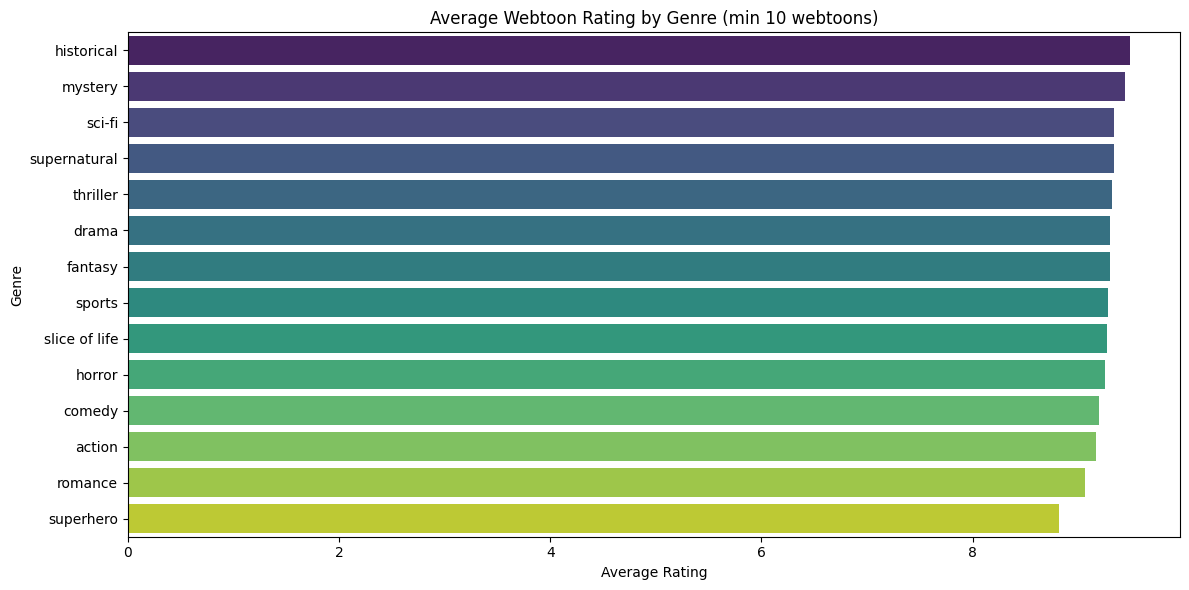

In [13]:
# Group by genre and compute average rating
we_genre_rating = df_we_genre.groupby('Genre')['Rating'].mean().sort_values(ascending=False)
we_genre_count = df_we_genre['Genre'].value_counts()

# Filter down to genres that appear in at least 10 webtoons
we_reliable_genres = we_genre_count[we_genre_count >= 10].index 
we_genre_rating_filtered = we_genre_rating[we_genre_rating.index.isin(we_reliable_genres)]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=we_genre_rating_filtered.values, y=we_genre_rating_filtered.index, palette='viridis')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Average Webtoon Rating by Genre (min 10 webtoons)')
plt.tight_layout()
plt.show

# ANOVA
groups = [group['Rating'].values for name, group in df_we_genre[df_we_genre['Genre'].isin(we_reliable_genres)].groupby('Genre')]
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_value:4f}")

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/4116998736.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_we_genres, x='Rating', y='Genre', palette='coolwarm')


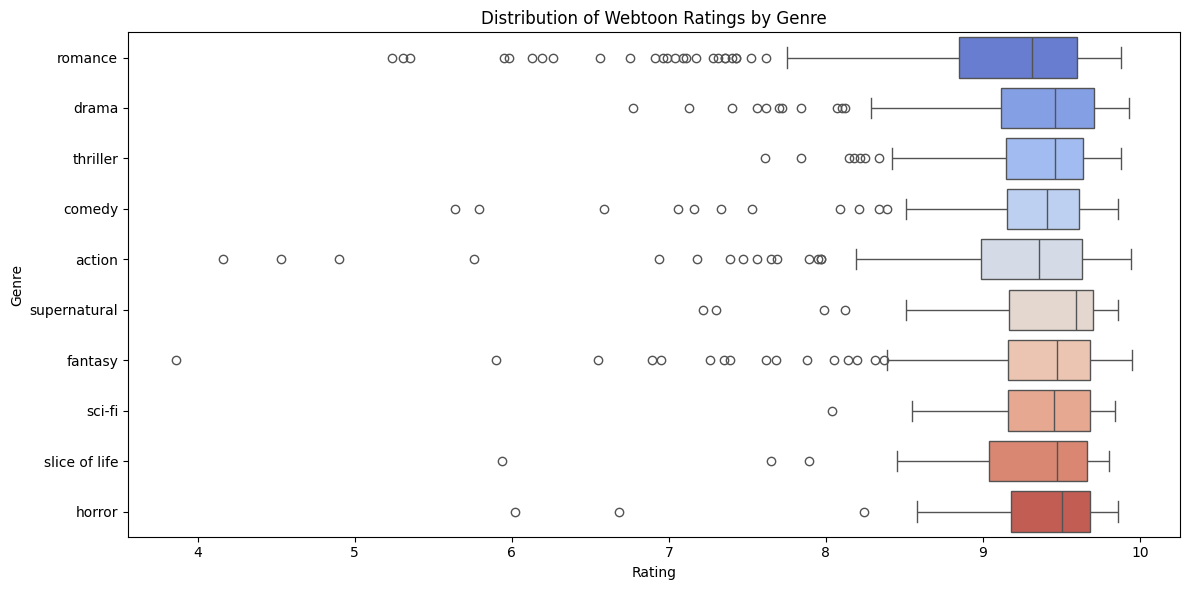

In [14]:
# Boxplot for webtoon genre vs rating

# Limit to top geres
top_we_genres = df_we_genre['Genre'].value_counts().head(10).index
df_top_we_genres = df_we_genre[df_we_genre['Genre'].isin(top_we_genres)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_we_genres, x='Rating', y='Genre', palette='coolwarm')
plt.title('Distribution of Webtoon Ratings by Genre')
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

* Ratings by genre is statistically significant. It is a meaningful predictor of webtoon rating
* Horror had the highest median rating and tigther spread. It is consistently well-received
* Slice of life and sci-fi also had high median ratings and tightly clustered scores
* Romance and drama had strong ratings, but more variability (wider boxes)
* Comedy, action, and thriller had slightly more outliers, suggesting variation in quality

## Views by genre

ANOVA F-statistic: 1.16, p-value: 0.305975


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/1644026309.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_views_sum.values, y=genre_views_sum.index, palette='viridis')


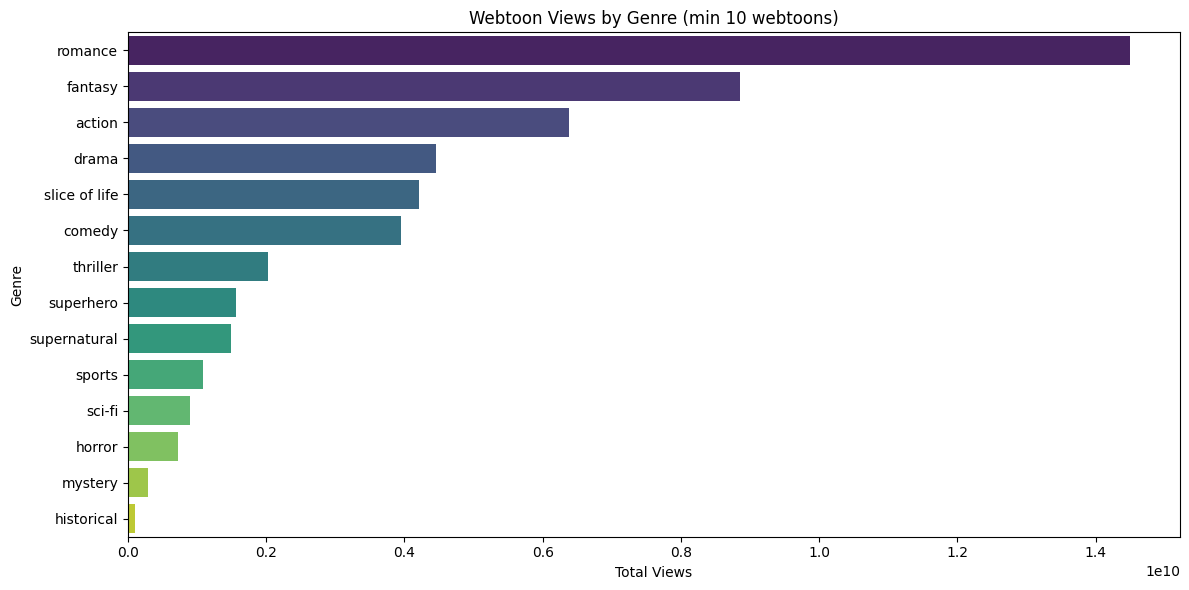

In [15]:
df_genre_views = df[['Genre', 'Views']].dropna()
df_genre_views['Views'] = df_genre_views['Views'].astype(int)

df_genre_views['Genre'] = df_genre_views['Genre'].str.lower().str.split(',')
df_genre_views = df_genre_views.explode('Genre')
df_genre_views['Genre'] = df_genre_views['Genre'].str.strip()

genre_views_counts = df_genre_views['Genre'].value_counts()
reliable_genres_views = genre_views_counts[genre_views_counts >= 10].index.tolist()

genre_views = df_genre_views[df_genre_views['Genre'].isin(reliable_genres_views)]
genre_views_sum = genre_views.groupby('Genre')['Views'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_views_sum.values, y=genre_views_sum.index, palette='viridis')
plt.xlabel('Total Views')
plt.ylabel('Genre')
plt.title('Webtoon Views by Genre (min 10 webtoons)')
plt.tight_layout()
plt.show

# ANOVA
groups = [group['Views'].values for name, group in df_genre_views[df_genre_views['Genre'].isin(reliable_genres_views)].groupby('Genre')]
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_value:4f}")

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/3615199403.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_genre_views_filtered, x='Views', y='Genre', palette='coolwarm')


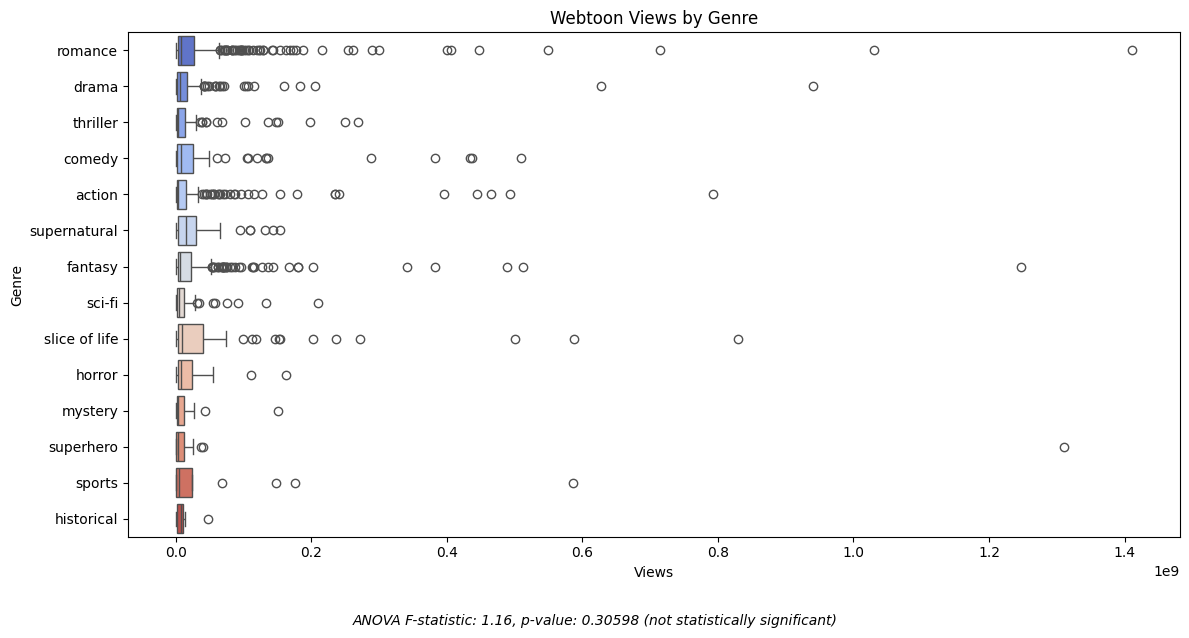

In [16]:
# Boxplot
df_genre_views_filtered = df_genre_views[df_genre_views['Genre'].isin(reliable_genres_views)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_genre_views_filtered, x='Views', y='Genre', palette='coolwarm')
plt.title('Webtoon Views by Genre')
plt.xlabel('Views')
plt.ylabel('Genre')

# Annotate p-value
plt.figtext(0.5, -0.05, f'ANOVA F-statistic: {f_stat:.2f}, p-value: {p_value:.5f} (not statistically significant)', 
            ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

* For views by genre, no statistical significance could be found
* Romance is the most populated genre, which explains its large variance in its rating
* Superhero has the highest outliers, but few samples
* Action, fantasy, and thriller have large variance and top-end outliers
* Historical, mystery, and sports have smaller boxes, fewer outliers, and lower average reach

## Likes by genre

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/2311958808.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_likes_sum.values, y=genre_likes_sum.index, palette='viridis')


ANOVA F-Statistic: 1.62, p-value: 0.073017


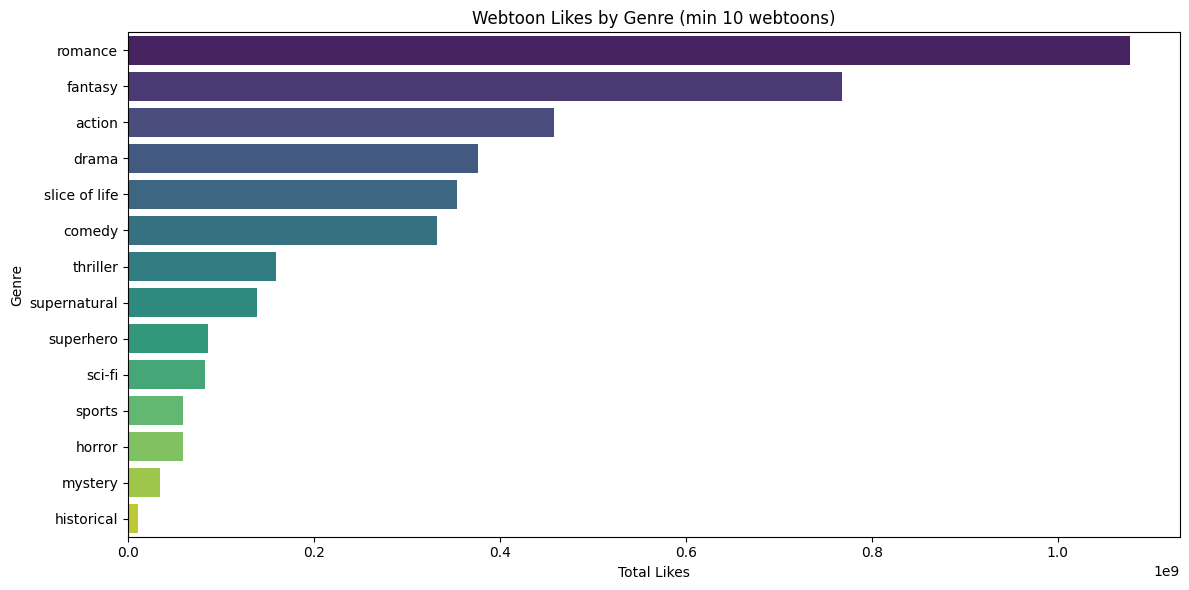

In [17]:
df_genre_likes = df[['Genre', 'Likes']].dropna()
df_genre_likes['Likes'] = df_genre_likes['Likes'].astype(int)

df_genre_likes['Genre'] = df_genre_likes['Genre'].str.lower().str.split(',')
df_genre_likes = df_genre_likes.explode('Genre')
df_genre_likes['Genre'] = df_genre_likes['Genre'].str.strip()

genre_likes_counts = df_genre_likes['Genre'].value_counts()
reliable_genres_likes = genre_likes_counts[genre_likes_counts >= 10].index.tolist()

genre_likes = df_genre_likes[df_genre_likes['Genre'].isin(reliable_genres_likes)]
genre_likes_sum = genre_likes.groupby('Genre')['Likes'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_likes_sum.values, y=genre_likes_sum.index, palette='viridis')
plt.xlabel('Total Likes')
plt.ylabel('Genre')
plt.title('Webtoon Likes by Genre (min 10 webtoons)')
plt.tight_layout()
plt.show 

# ANOVA
groups = [group['Likes'].values for name, group in df_genre_likes[df_genre_likes['Genre'].isin(reliable_genres_likes)].groupby('Genre')]
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F-Statistic: {f_stat:.2f}, p-value: {p_value:4f}")

* Number of likes does not have statistical significance in genre popularity

## Subscribers by genre

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/3425177591.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_subs_sum.values, y=genre_subs_sum.index, palette='viridis')


ANOVA F-statistic: 2.49, p-value: 0.002296


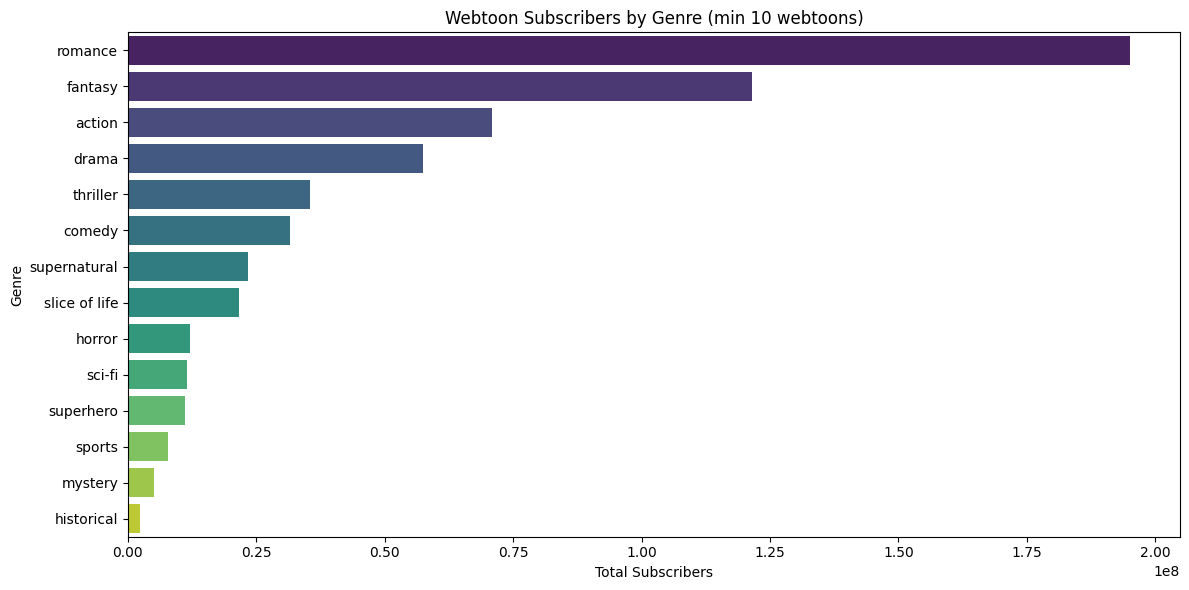

In [18]:
df_genre_subs = df[['Genre', 'Subscribers']].dropna()
df_genre_subs['Subscribers'] = df_genre_subs['Subscribers'].astype(int)

df_genre_subs['Genre'] = df_genre_subs['Genre'].str.lower().str.split(',')
df_genre_subs = df_genre_subs.explode('Genre')
df_genre_subs['Genre'] = df_genre_subs['Genre'].str.strip()

genre_subs_count = df_genre_subs['Genre'].value_counts()
reliable_genre_subs = genre_subs_count[genre_subs_count >= 10].index.tolist()

genre_subs = df_genre_subs[df_genre_subs['Genre'].isin(reliable_genre_subs)]
genre_subs_sum = genre_subs.groupby('Genre')['Subscribers'].sum().sort_values(ascending=False)

# Plot 
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_subs_sum.values, y=genre_subs_sum.index, palette='viridis')
plt.xlabel('Total Subscribers')
plt.ylabel('Genre')
plt.title('Webtoon Subscribers by Genre (min 10 webtoons)')
plt.tight_layout()
plt.show 

# ANOVA
groups = [group['Subscribers'].values for name, group in df_genre_subs[df_genre_subs['Genre'].isin(reliable_genre_subs)].groupby('Genre')]
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_value:4f}")

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/3726788386.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_genre_subs_filtered, x='Subscribers', y='Genre', palette='coolwarm')


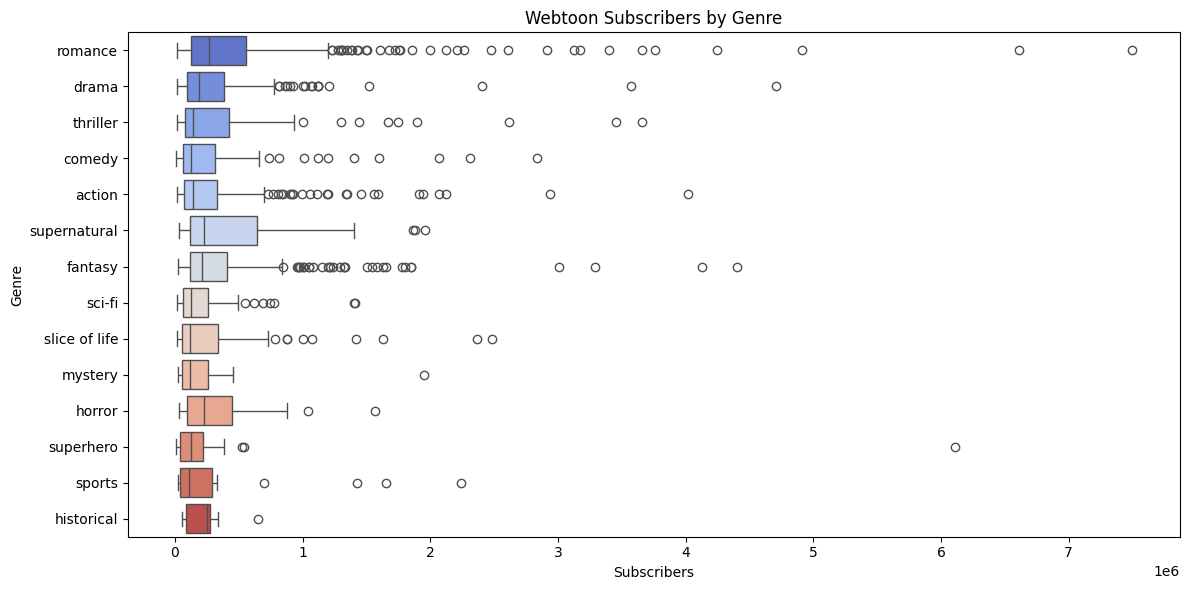

In [19]:
# Boxplot
df_genre_subs_filtered = df_genre_subs[df_genre_subs['Genre'].isin(reliable_genre_subs)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_genre_subs_filtered, x='Subscribers', y='Genre', palette='coolwarm')
plt.title('Webtoon Subscribers by Genre')
plt.xlabel('Subscribers')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

* Romance has the widest spread of subscribers (lots of variability). 
    * It also has extreme outliers, with some titles having high subscriber counts
    * Relatively high median
* Drama and thriller have significant spreads and outliers, but not as extreme as romance
    * Indicates popularity but has less extreme highs
* Comedy, action, supernatural, and fantasy show moderate spread and many outliers
* Historical, sports, superhero and horror tend to have lower medians and smaller spreads
    * Fewer or no high outliers
    * These genres are less popular or have fewer hits (outliers)
* The large presence of outliers show that there are a few pouplar titles that are skewing the distribution

## Popular genre over time
* Heatmap showing the genre popularity over time

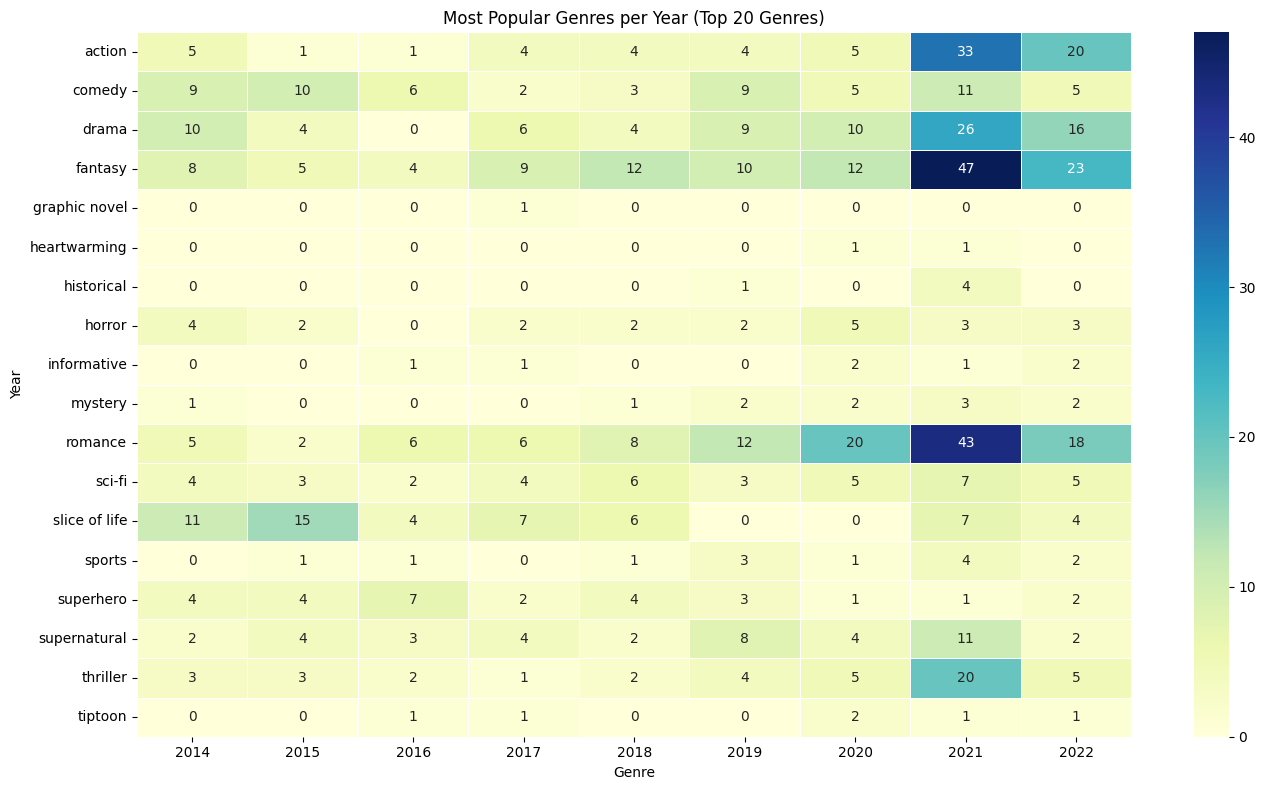

Chi-square Statistic: 249.92066002854426
Degrees of Freedom: 136
P-value: 9.502159204842587e-09
There is statistical significance between genre and year.


In [20]:
df_genre_year = df[['Release Date', 'Genre']].dropna(subset=['Genre', 'Release Date'])
df_genre_year['Genre'] = df_genre_year['Genre'].str.lower().str.split(',')
df_genre_year = df_genre_year.explode('Genre')
df_genre_year['Genre'] = df_genre_year['Genre'].str.strip()

df_genre_year['Release Date'] = df_genre_year['Release Date'].astype(int)

genre_counts_year = df_genre_year.groupby(['Release Date', 'Genre']).size().reset_index(name='Count')
top_year_genres = genre_counts_year.groupby('Genre')['Count'].sum().sort_values(ascending=False).head(20).index
genre_counts_year = genre_counts_year[genre_counts_year['Genre'].isin(top_year_genres)]
genre_pivot = genre_counts_year.pivot(index='Genre', columns='Release Date', values='Count').fillna(0)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(genre_pivot, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=0.5)
plt.title('Most Popular Genres per Year (Top 20 Genres)')
plt.xlabel('Release Date')
plt.ylabel('Year')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

# Chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(genre_pivot)

print(f"Chi-square Statistic: {chi2_stat}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p_val}")

if p_val < 0.05:
    print("There is statistical significance between genre and year.")
else:
    print("There is no statistical significance between genre and year.")


* The statistical significance between genre and year show that the distribution of popular genres changes meaningfully over time and is not due to random variation
    * Clear shift in audience preference over time
* Romance and fantasy started growing significantly from 2018 onward
    * Experienced spikes in 2021
* Drama and action experienced large increase in popularity, especially in 2021
    * Drama has demonstrated strong growht from 2018 to 2021
    * Action has shows big jump in 2021
* Thriller and supernatural experienced noticeable increase in 2020-2021, but not as large as fantasy/romance
* Slice of life showed strong popularity from 2014 to 2015, but decreased over time
* Comedy and sci-fi have shown moderate popularity across all years, but no massive spikes
* Graphic novel, heartwarming, historical, informative, and tiptoon tend to rarely apper in the top 20

## Top titles of popular genres & release year

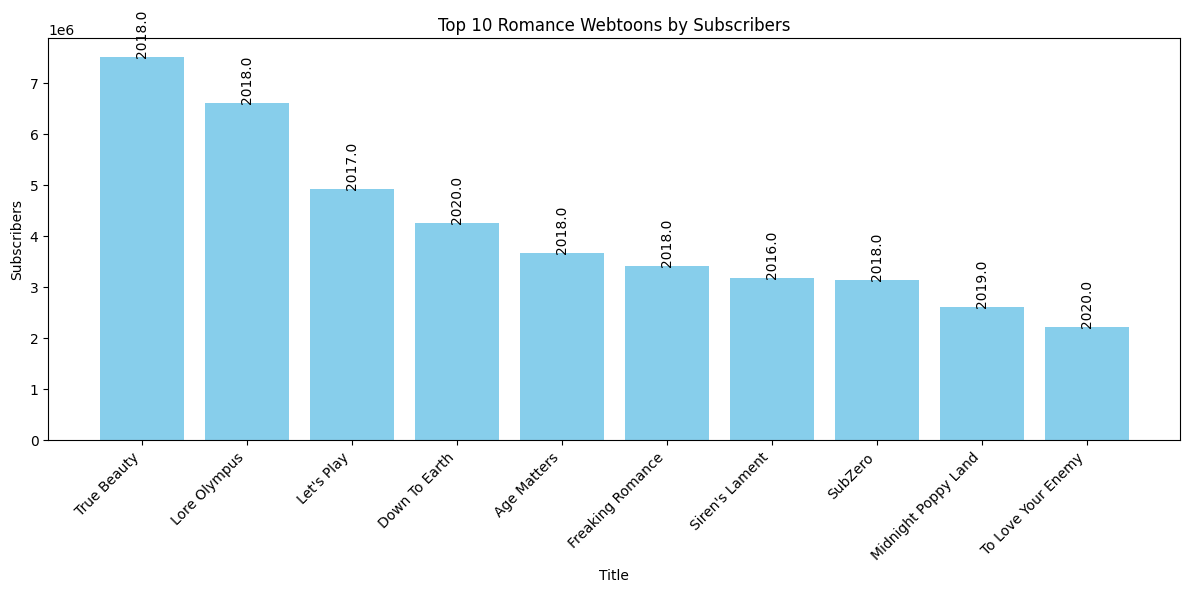

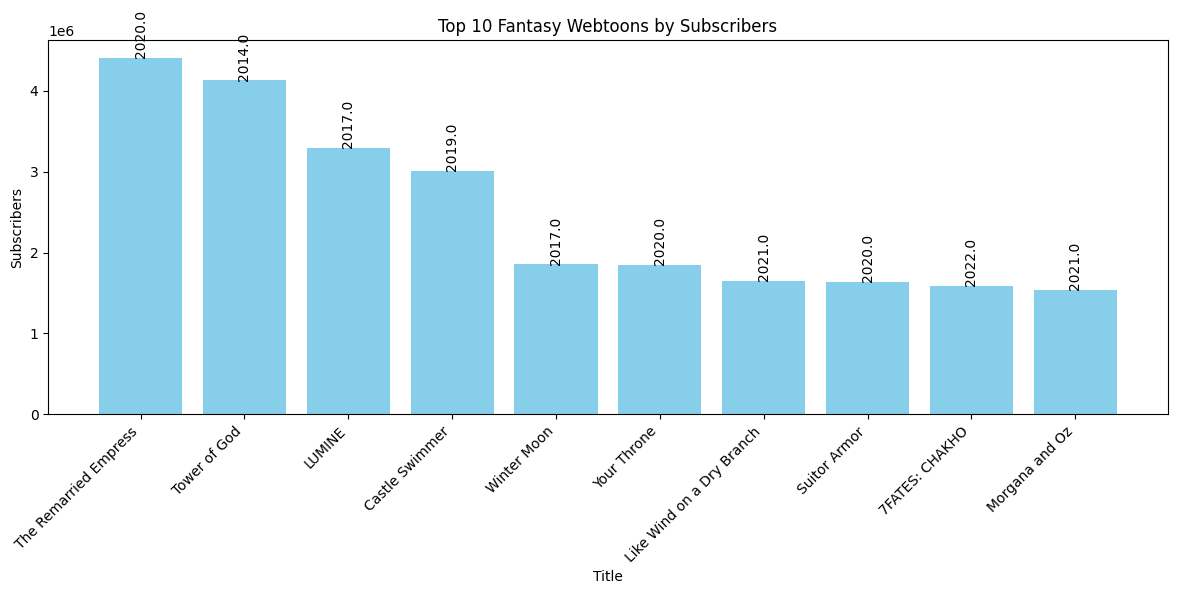

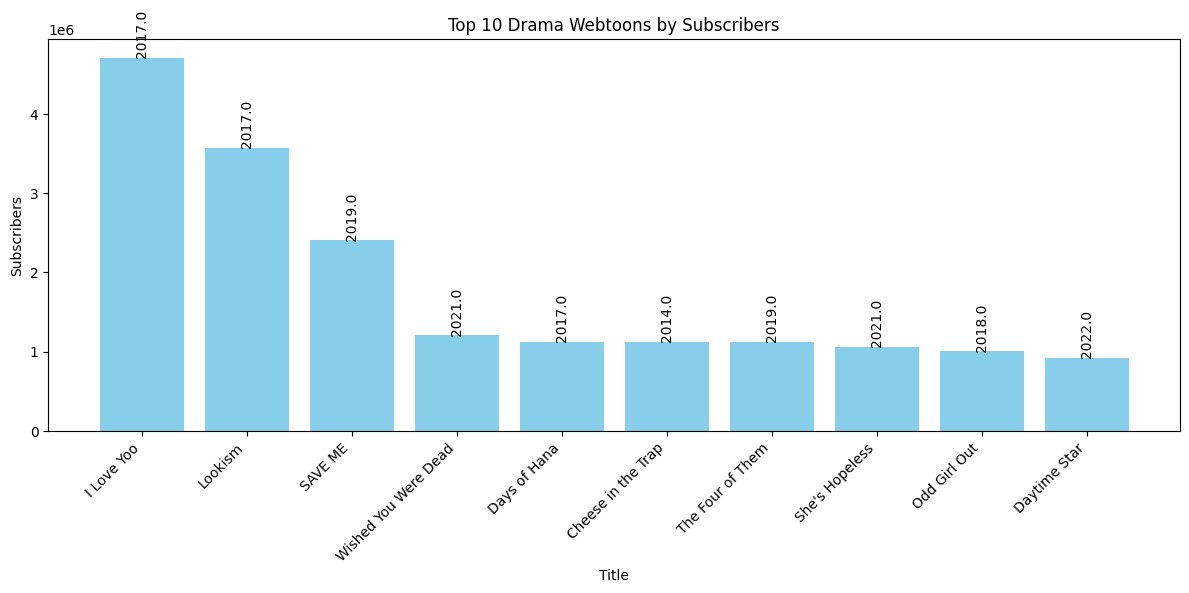

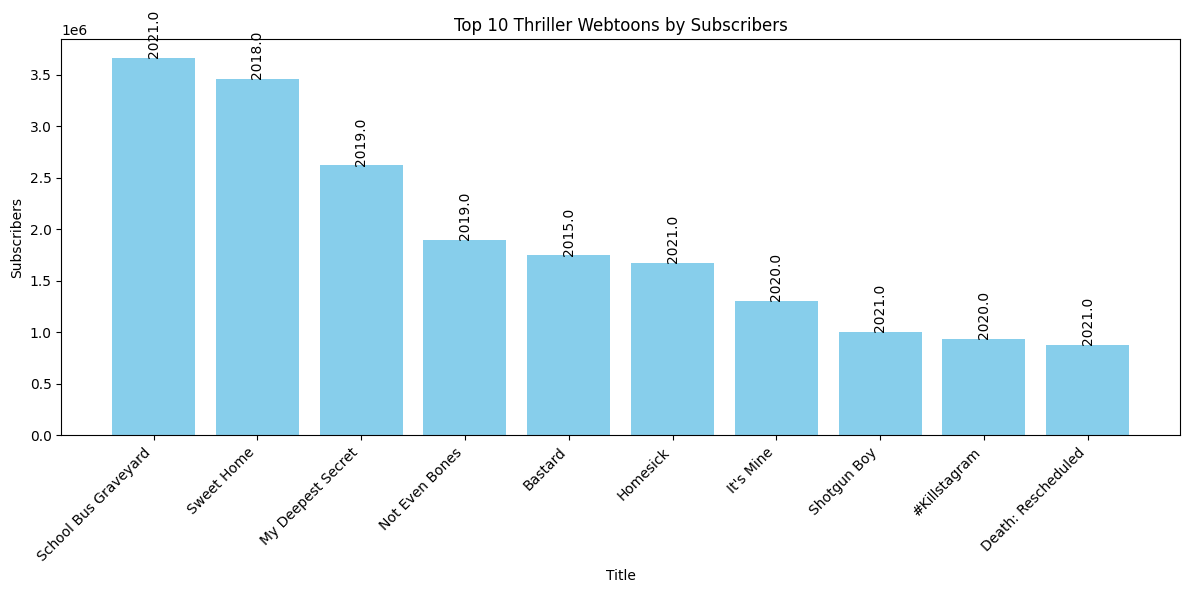

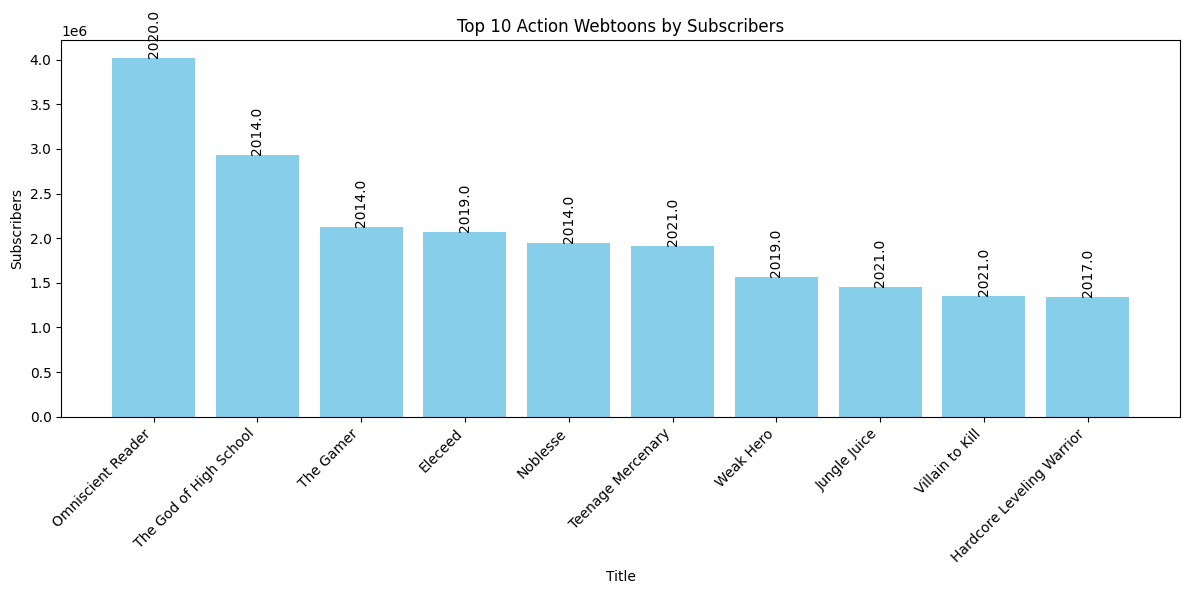

In [21]:
target_genres = ['romance', 'fantasy', 'drama', 'thriller', 'action']
df_clean = df[['Genre', 'Title', 'Subscribers', 'Release Date']].dropna()

# Filter for only target genres
df_top10_genre_list = df_clean[df_clean['Genre'].str.lower().isin(target_genres)]

# Get top 10 by subscribers per genre
top_10_per_genre = (
    df_top10_genre_list
    .sort_values(['Genre', 'Subscribers'], ascending=[True, False])
    .groupby('Genre')
    .head(10)
    .reset_index(drop=True)
)

# Bar graph for top 10 most popular genre + its release year
for genre in target_genres:
    genre_df = top_10_per_genre[top_10_per_genre['Genre'] == genre].sort_values(by='Subscribers', ascending=False)
    plt.figure(figsize=(12, 6))
    bars = plt.bar(genre_df['Title'], genre_df['Subscribers'], color='skyblue')
    for bar, release_date in zip(bars, genre_df['Release Date']):
        label = str(release_date.date()) if hasattr(release_date, 'date') else str(release_date)
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            label,
            ha='center',
            va='bottom',
            fontsize=10,
            rotation=90
        )
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top 10 {genre.capitalize()} Webtoons by Subscribers')
    plt.xlabel('Title')
    plt.ylabel('Subscribers')
    plt.tight_layout()
    plt.show()

# Creator-based

## Rating by creator
* Some creators may appear once in the dataset. The goal is to identify creators who have shown a proven track record of producing content that increases the chances of a successful adaptation
* To avoid one-hit wonders (outliers) that may lead to overemphasis on anomaly success, the average rating of creators with more than 2 titles will be measured 
* Bar graphs and standard deviation of ratings (some creators may be hit-or-miss) will be included 
* Following metrics for creators will be measured to see:
    * Rating for perceived quality of creator's works
    * Views for reach/exposure
    * Likes for engagement/emotional response of the creator's works
    * Subscribers for fanbase loyalty

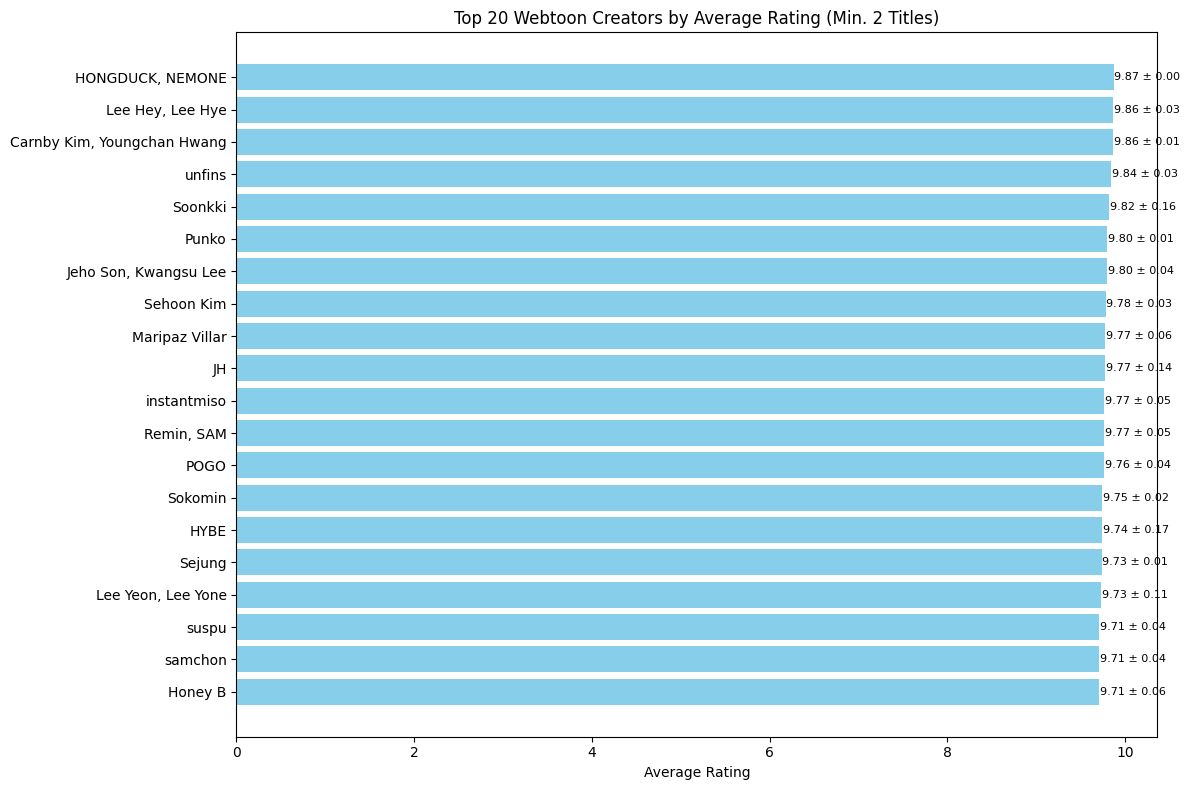

In [22]:
df_creator_rating = df[['Creators', 'Rating']].dropna()

creator_stats = df_creator_rating.groupby('Creators')['Rating'].agg(['count', 'mean', 'std'])
creator_stats = creator_stats[creator_stats['count'] >= 2]

top_20_creators = creator_stats.sort_values('mean', ascending=False).head(20)

# Plot 
plt.figure(figsize=(12, 8))
bars = plt.barh(top_20_creators.index, top_20_creators['mean'], color='skyblue')
plt.xlabel('Average Rating')
plt.title('Top 20 Webtoon Creators by Average Rating (Min. 2 Titles)')
plt.gca().invert_yaxis()

# Std deviation
for bar, avg, std in zip(bars, top_20_creators['mean'], top_20_creators['std']):
    width = bar.get_width()
    label = f'{avg:.2f} ± {std:.2f}'
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, label, va='center', fontsize=8)

plt.tight_layout()
plt.show()

* As shown in the graph, no creators have been found to have high variability
* A few creators such as Soonkki, JH, HYBE, Lee Yeon, Lee Yone have moderate variation, indicating some inconsistency across their works
* Most creators are highly consistent 

In [23]:
# ANOVA for creators and rating
creator_counts = df_creator_rating['Creators'].value_counts()
valid_creators = creator_counts[creator_counts >= 2].index
df_creators_filtered = df_creator_rating[df_creator_rating['Creators'].isin(valid_creators)]

grouped_views = [group['Rating'].values for _, group in df_creators_filtered.groupby('Creators')]

f_stat, p_val = f_oneway(*grouped_views)

print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("There is statistical significance in rating among creators")
else:
    print("There is no statistical significance in rating among creators")

ANOVA F-statistic: 3.3728
P-value: 1.4082e-12
There is statistical significance in rating among creators


In [24]:
# Creator frequency in top 20 highest-rated webtoons
# Identify creators that may be overrepresented in the top 20 highest-rated works

df_top20_rated =df.sort_values('Rating', ascending=False).dropna(subset=['Creators']).head(20)
observed = df_top20_rated['Creators'].value_counts()
total_counts = df['Creators'].value_counts()

all_creators = observed.index.union(total_counts.index)
observed = observed.reindex(all_creators, fill_value=0)
total_counts = total_counts.reindex(all_creators, fill_value=0)

expected = total_counts * (len(df_top20_rated) / len(df))
expected = expected * (observed.sum() / expected.sum())


# Chi-Square Test
chi2_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_val:.4e}")

if p_val < 0.05:
    print("Statistically significant: some creators appear in top 20 more often than expected")
else:
    print("No significant differnece. Creator frequency may be due to chance")

Chi-Square Statistic: 1390.3000
P-Value: 6.2642e-01
No significant differnece. Creator frequency may be due to chance


In [25]:
# Sort and display observed vs expected difference
result_table = pd.DataFrame({
    'Observed': observed,
    'Expected': expected,
    'Difference (Obs - Exp)': observed - expected
}).sort_values('Difference (Obs - Exp)', ascending=False)

# Display full table
pd.set_option('display.max_rows', None)  # show all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.colheader_justify', 'left')
print(result_table[result_table['Difference (Obs - Exp)'] > 0].head(10))

                                       Observed  Expected  \
Creators                                                    
HONGDUCK, NEMONE                       2         0.025526   
IAN, Kanara, Lee Hyun Min, SOULPUNG    1         0.012763   
GOMYANG                                1         0.012763   
Sleepy-C, UMI, sing N song, singNsong  1         0.012763   
Hyeon A Cho                            1         0.012763   
Han Kyoung Chal, han kyoung chal       1         0.012763   
moonkyoung kim                         1         0.012763   
Kwon Sora, Seo Jaewon, ch              1         0.012763   
Yongseok Jo                            1         0.012763   
Ephemerys, Sophism                     1         0.012763   

                                       Difference (Obs - Exp)  
Creators                                                       
HONGDUCK, NEMONE                       1.974474                
IAN, Kanara, Lee Hyun Min, SOULPUNG    0.987237                
GOMYANG    

ANOVA
* Accounts differences in average ratings across creators (not limited to top 20)
* Some creators receive consistently high or low average ratings

Chi-Square
* Across top-rated works, there is not statitical significance in difference in how often creators appear in top-rated works
* While some creators appear more than others in the top 20, the frequency isn't significantly different from what would be expected by chance given their overall output
    * Having more work alone doesn't explain high ratings
    * Quality of the work is more important than sheer frequency
* Top-rated titles isn't dominated by a group of creators. It's relatively balanced in frequency

## Views by creator

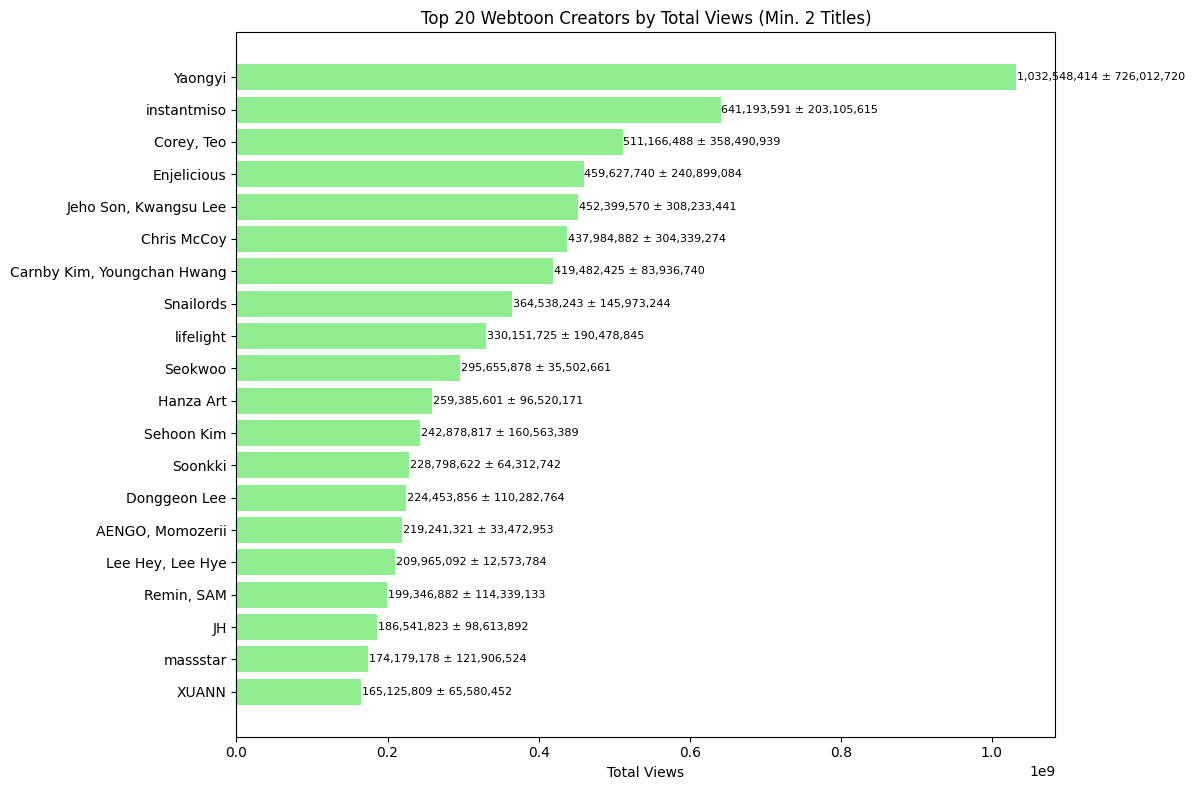

In [26]:
df_creator_views = df[['Creators', 'Views']].dropna()

creator_view_stats = df_creator_views.groupby('Creators')['Views'].agg(['count', 'sum', 'mean', 'std'])
creator_view_stats = creator_view_stats[creator_view_stats['count'] >= 2]

top_20_views = creator_view_stats.sort_values('sum', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(top_20_views.index, top_20_views['sum'], color='lightgreen')
plt.xlabel('Total Views')
plt.title('Top 20 Webtoon Creators by Total Views (Min. 2 Titles)')
plt.gca().invert_yaxis()

# Std deviation
for bar, total, std in zip(bars, top_20_views['sum'], top_20_views['std']):
    width = bar.get_width()
    label = f'{int(total):,} ± {int(std):,}'
    plt.text(width + 1e6, bar.get_y() + bar.get_height() / 2, label, va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [27]:
# Run ANOVA for creators (w/ at least 2 titles)
creator_counts = df_creator_views['Creators'].value_counts()
valid_creators = creator_counts[creator_counts >= 2].index
df_creators_filtered = df_creator_views[df_creator_views['Creators'].isin(valid_creators)]

grouped_views = [group['Views'].values for _, group in df_creators_filtered.groupby('Creators')]

f_stat, p_val = f_oneway(*grouped_views)

print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("There is statistical significance in views among creators")
else:
    print("There is no statistical significance in views among creators")

ANOVA F-statistic: 1.3214
P-value: 5.6342e-02
There is no statistical significance in views among creators


In [28]:
# Creator frequency in top 20 highest-viewed webtoons
# Identify creators that may be overrepresented in the top 20 highest-viewed webtoons

df_top20_views = df.sort_values('Views', ascending=False).dropna(subset=['Creators']).head(20)
observed = df_top20_views['Creators'].value_counts()
total_counts = df['Creators'].value_counts()

all_creators = observed.index.union(total_counts.index)
observed = observed.reindex(all_creators, fill_value=0)
total_counts = total_counts.reindex(all_creators, fill_value=0)

expected = total_counts * (len(df_top20_views) / len(df))
expected = expected * (observed.sum() / expected.sum())

# Chi-square test
chi2_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-Square Statistic: {chi2_stat:.4f}")

if p_val < 0.05:
    print("Statistically significant: some creators appear in top 20 more of than expected")
else: 
    print("No significant difference. Creator frequency may be due to chance when it comes to views")

# Sort and display observed vs expected difference
result_table = pd.DataFrame({
    'Observed': observed,
    'Expected': expected,
    'Difference (Obs - Exp)': observed - expected
}).sort_values('Difference (Obs - Exp)', ascending=False)

# Display full table
pd.set_option('display.max_rows', None)  # show all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.colheader_justify', 'left')
print(result_table[result_table['Difference (Obs - Exp)'] > 0].head(10))

Chi-Square Statistic: 1377.2417
No significant difference. Creator frequency may be due to chance when it comes to views
                                       Observed  Expected  \
Creators                                                    
Pookie Senpai                          1         0.012763   
Rachel Smythe                          1         0.012763   
fishball                               1         0.012763   
Alphatart, HereLee, Sumpul             1         0.012763   
Sang-A, Sangyoung Seong                1         0.012763   
Sleepy-C, UMI, sing N song, singNsong  1         0.012763   
SIU                                    1         0.012763   
Yongseok Jo                            1         0.012763   
Yongje Park                            1         0.012763   
Taejun Pak                             1         0.012763   

                                       Difference (Obs - Exp)  
Creators                                                       
Pookie Senpai     

## Likes by creators

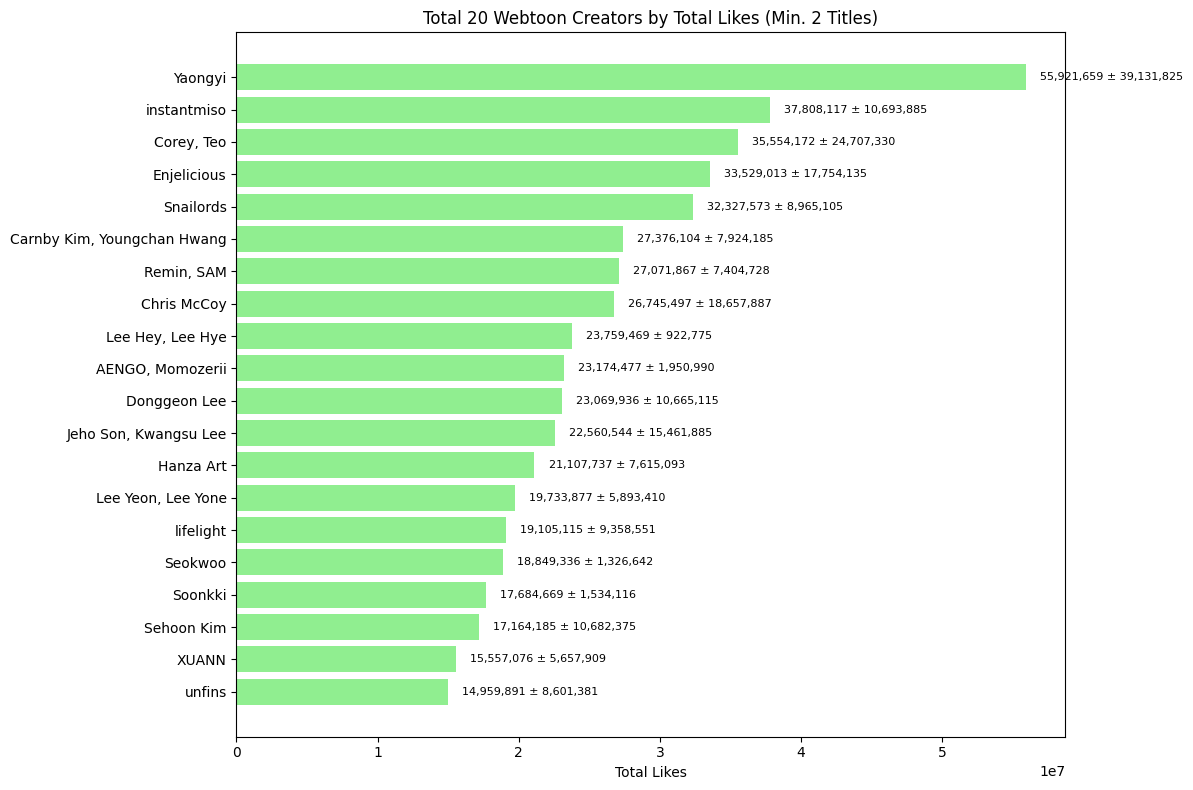

In [29]:
df_creator_likes = df[['Creators', 'Likes']].dropna()

creator_likes_stats = df_creator_likes.groupby('Creators')['Likes'].agg(['count', 'sum', 'mean', 'std'])
creator_likes_stats = creator_likes_stats[creator_likes_stats['count'] >= 2]

top_20_likes = creator_likes_stats.sort_values('sum', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(top_20_likes.index, top_20_likes['sum'], color='lightgreen')
plt.xlabel('Total Likes')
plt.title('Total 20 Webtoon Creators by Total Likes (Min. 2 Titles)')
plt.gca().invert_yaxis()

# Std deviation
for bar, total, std in zip(bars, top_20_likes['sum'], top_20_likes['std']):
    width = bar.get_width()
    label = f'{int(total):,} ± {int(std):,}'
    plt.text(width + 1e6, bar.get_y() + bar.get_height()/2, label, va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [30]:
# ANOVA
creator_counts = df_creator_likes['Creators'].value_counts()
valid_creators = creator_counts[creator_counts >= 2].index
df_creator_filtered = df_creator_likes[df_creator_likes['Creators'].isin(valid_creators)]

grouped_likes = [group['Likes'].values for _, group in df_creator_filtered.groupby('Creators')]

f_stat, p_val = f_oneway(*grouped_likes)

print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("There is statistical significance in likes among creators")
else:
    print("There is no statistical significance in likes among creators")

ANOVA F-statistic: 1.4557
P-value: 1.4916e-02
There is statistical significance in likes among creators


In [31]:
# Breakdown of likes per title
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

df_creator_likes_title = df[['Creators', 'Title', 'Likes']].dropna()

creator_counts = df_creator_likes['Creators'].value_counts()
eligible_creators = creator_counts[creator_counts >= 2].index
df_creator_likes_title = df_creator_likes_title[df_creator_likes_title['Creators'].isin(eligible_creators)]

top_20_creators_total_likes = (
    df_creator_likes_title.groupby('Creators')['Likes']
    .sum()
    .sort_values(ascending=False)
)

top_20_creators = top_20_creators_total_likes.head(20).index

df_top20_titles_likes = df_creator_likes_title[df_creator_likes_title['Creators'].isin(top_20_creators)]
df_top20_titles_likes['Likes Breakdown'] = df_top20_titles_likes['Likes'].apply(lambda x: f"{int(x):,}")
df_top20_titles_likes['Total Likes'] = df_top20_titles_likes['Creators'].map(top_20_creators_total_likes)
df_sorted_likes = df_top20_titles_likes.sort_values(by=['Total Likes', 'Likes'], ascending=[False, False])

output = df_sorted_likes[['Creators', 'Title', 'Likes Breakdown']]
print(output.to_string(index=False))

Creators                    Title                                   Likes Breakdown
                    Yaongyi                             True Beauty 55,631,209     
                    Yaongyi                        Return Your Soul    290,450     
                instantmiso                          Siren's Lament 24,139,391     
                instantmiso                      Eaternal Nocturnal 10,647,217     
                instantmiso                     Where Tangents Meet  3,021,509     
                 Corey, Teo                       Adventures of God 35,247,807     
                 Corey, Teo                     Cat Got Your Tongue    306,365     
                Enjelicious                             Age Matters 29,318,576     
                Enjelicious                              Hello Baby  4,210,437     
                  Snailords                        Freaking Romance 21,426,194     
                  Snailords                      Death: Rescheduled  5,193,6

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/2842708006.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top20_titles_likes['Likes Breakdown'] = df_top20_titles_likes['Likes'].apply(lambda x: f"{int(x):,}")
/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/2842708006.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top20_titles_likes['Total Likes'] = df_top20_titles_likes['Creators'].map(top_20_creators_total_likes)


In [32]:
# Creator frequency in top 20 highest-liked webtoons
# Identify crators that may be overrepresented in the top 20 highest-liked works

df_top20_likes =df.sort_values('Likes', ascending=False).dropna(subset=['Creators']).head(20)
observed = df_top20_likes['Creators'].value_counts()
total_counts = df['Creators'].value_counts()

all_creators = observed.index.union(total_counts.index)
observed = observed.reindex(all_creators, fill_value=0)
total_counts = total_counts.reindex(all_creators, fill_value=0)

expected = total_counts * (len(df_top20_likes) / len(df))
expected = expected * (observed.sum() / expected.sum())

# Chi-Square Test
chi2_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_val:.4e}")

if p_val < 0.05:
    print("Statistically significant: some creators appear in top 20 more often than expected")
else:
    print("No significant difference. Creator frequency may be due to chance")

# Observed vs expected difference
result_table = pd.DataFrame({
    'Observed': observed,
    'Expected': expected,
    'Difference (Obs - Exp)': observed - expected
}).sort_values('Difference (Obs - Exp)', ascending=False)

# Display full table
pd.set_option('display.max_rows', None)  # show all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.colheader_justify', 'left')
print(result_table[result_table['Difference (Obs - Exp)'] > 0].head(10))

Chi-Square Statistic: 1390.3000
P-Value: 6.2642e-01
No significant difference. Creator frequency may be due to chance
                            Observed  Expected  Difference (Obs - Exp)
Creators                                                              
SIU                         1         0.012763  0.987237              
uru-chan                    1         0.012763  0.987237              
Alphatart, HereLee, Sumpul  1         0.012763  0.987237              
Leeanne M. Krecic (Mongie)  1         0.012763  0.987237              
Taejun Pak                  1         0.012763  0.987237              
Rachel Smythe               1         0.012763  0.987237              
Jeho Son, ZHENA             1         0.012763  0.987237              
Wendy Lian Martin           1         0.012763  0.987237              
Yongje Park                 1         0.012763  0.987237              
Shen                        1         0.012763  0.987237              


* Yaongyi has the largest number of likes, but also very high variability (±39M)
    * As the breakdown of likes show it's due to her work True Beauty, which massively outperforms her other title
* Similarly, Corey and Teo's high variability (±24M and ±18M) is attributed to Adventures of God outperforming their other title 
* For creators like Yaongyi and Corey and Teo, there is inconsistent audience reception across works
* Lee Hye and Soonkki have high like counts with low standard deviations. They have consistent popularity across titles
* High standard deviation creators may have breakout webtoon hits, but tend to be more risky since their performance isn't as predictable
* Creators who have high average likes and low standard deviation are strong candidates for continuous success   
* While the ANOVA test showed that there is statistical significance in creators when it comes to number of likes, in the top 20 most-liked webstoons, there is no significance. The top most liked isn't dominated by a small group of creators, it's relatively balanced with different creators

# Subscribers by creator
* In WEBTOONS page, users can subscribe to a story (not necessarily the creator)
* Some creators may have an uneven number of subscribers distribution since a title may be a hit while other ones may not

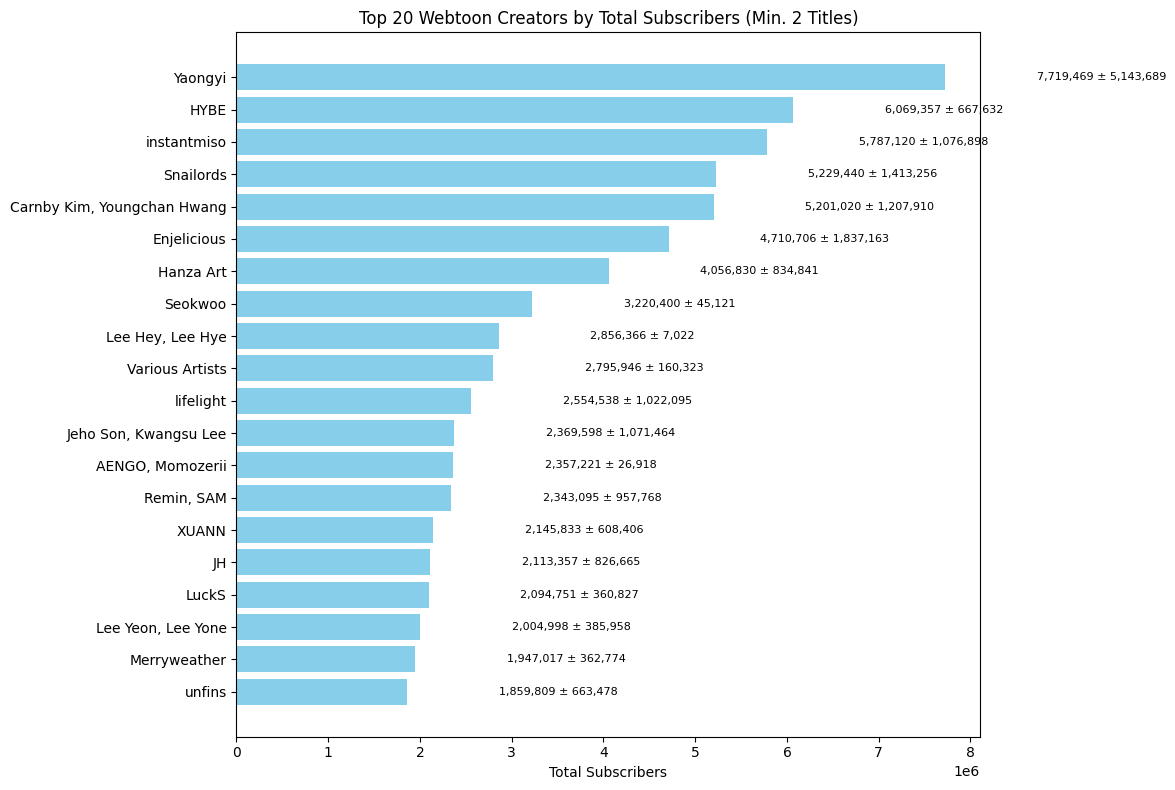

In [33]:
df_creator_sub = df[['Creators', 'Subscribers']].dropna()
creator_sub_stats = df_creator_sub.groupby('Creators')['Subscribers'].agg(['count', 'sum', 'mean', 'std'])
creator_sub_stats = creator_sub_stats[creator_sub_stats['count'] >= 2]

top_20_sub = creator_sub_stats.sort_values('sum', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(top_20_sub.index, top_20_sub['sum'], color='skyblue')
plt.xlabel('Total Subscribers')
plt.title('Top 20 Webtoon Creators by Total Subscribers (Min. 2 Titles)')
plt.gca().invert_yaxis()

# Std deviation
for bar, total, std in zip(bars, top_20_sub['sum'], top_20_sub['std']):
    width = bar.get_width()
    label = f'{int(total):,} ± {int(std):,}'
    plt.text(width + 1e6, bar.get_y() + bar.get_height()/2, label, va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [34]:
# ANOVA
creator_counts = df_creator_sub['Creators'].value_counts()
valid_creators = creator_counts[creator_counts >= 2].index
df_creator_filtered = df_creator_sub[df_creator_sub['Creators'].isin(valid_creators)]

grouped_sub = [group['Subscribers'].values for _, group in df_creator_filtered.groupby('Creators')]

f_stat, p_val = f_oneway(*grouped_sub)

print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("There is statistical significance in subscribers among creators")
else:
    print("There is not statistical significance in subscribers among creators")

ANOVA F-statistic: 1.9930
P-value: 3.3127e-05
There is statistical significance in subscribers among creators


In [35]:
# Breakdown of subscribers per creator's title
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

df_creator_sub_title = df[['Creators', 'Title', 'Subscribers']].dropna()

creator_counts = df_creator_sub['Creators'].value_counts()
eligible_creators = creator_counts[creator_counts >= 2].index
df_creator_sub_title = df_creator_sub_title[df_creator_sub_title['Creators'].isin(eligible_creators)]

top_20_creators_total_sub = (
    df_creator_sub_title.groupby('Creators')['Subscribers']
    .sum()
    .sort_values(ascending=False)
)

top_20_creators = top_20_creators_total_sub.head(20).index

df_top20_title_sub = df_creator_sub_title[df_creator_sub_title['Creators'].isin(top_20_creators)]
df_top20_title_sub['Subs Breakdown'] = df_top20_title_sub['Subscribers'].apply(lambda x: f"{int(x):,}")
df_top20_title_sub['Total Subs'] = df_top20_title_sub['Creators'].map(top_20_creators_total_sub)
df_storted_subs = df_top20_title_sub.sort_values(by=['Total Subs', 'Subscribers'], ascending=[False, False])

output = df_storted_subs[['Creators', 'Title', 'Subs Breakdown']]
print(output.to_string(index=False))

Creators                    Title                                            Subs Breakdown
                    Yaongyi                                      True Beauty 7,496,872     
                    Yaongyi                                 Return Your Soul   222,597     
                       HYBE                       DARK MOON: THE BLOOD ALTAR 1,775,799     
                       HYBE                                   7FATES: CHAKHO 1,585,911     
                       HYBE                        DARK MOON:THE BLOOD ALTAR 1,200,000     
                       HYBE                                 THE STAR SEEKERS   815,220     
                       HYBE               CHILDREN OF VAMFIELD  by DARK MOON   263,511     
                       HYBE                         DARK MOON: THE GREY CITY   248,066     
                       HYBE                                    Crimson Heart   180,850     
                instantmiso                                   Siren's Lament 3,1

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/61116188.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top20_title_sub['Subs Breakdown'] = df_top20_title_sub['Subscribers'].apply(lambda x: f"{int(x):,}")
/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/61116188.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top20_title_sub['Total Subs'] = df_top20_title_sub['Creators'].map(top_20_creators_total_sub)


In [36]:
# Creator frequency in top 20 highest-subscribed webtoons
# Identify crators that may be overrepresented in the top 20 highest-subscribed works

df_top20_subscribed =df.sort_values('Subscribers', ascending=False).dropna(subset=['Creators']).head(20)
observed = df_top20_subscribed['Creators'].value_counts()
total_counts = df['Creators'].value_counts()

all_creators = observed.index.union(total_counts.index)
observed = observed.reindex(all_creators, fill_value=0)
total_counts = total_counts.reindex(all_creators, fill_value=0)

expected = total_counts * (len(df_top20_subscribed) / len(df))
expected = expected * (observed.sum() / expected.sum())


# Chi-Square Test
chi2_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_val:.4e}")

if p_val < 0.05:
    print("Statistically significant: some creators appear in top 20 more often than expected")
else:
    print("No significant difference. Creator frequency may be due to chance")

# Observed vs expected difference
result_table = pd.DataFrame({
    'Observed': observed,
    'Expected': expected,
    'Difference (Obs - Exp)': observed - expected
}).sort_values('Difference (Obs - Exp)', ascending=False)

# Display full table
pd.set_option('display.max_rows', None)  # show all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.colheader_justify', 'left')
print(result_table[result_table['Difference (Obs - Exp)'] > 0].head(10))

Chi-Square Statistic: 1318.4792
P-Value: 9.5650e-01
No significant difference. Creator frequency may be due to chance
                            Observed  Expected  Difference (Obs - Exp)
Creators                                                              
Taejun Pak                  1         0.012763  0.987237              
uru-chan                    1         0.012763  0.987237              
Yongje Park                 1         0.012763  0.987237              
Leeanne M. Krecic (Mongie)  1         0.012763  0.987237              
Red, lilredbeany            1         0.012763  0.987237              
Alphatart, HereLee, Sumpul  1         0.012763  0.987237              
SIU                         1         0.012763  0.987237              
Rachel Smythe               1         0.012763  0.987237              
Wendy Lian Martin           1         0.012763  0.987237              
Emma Krogell                1         0.012763  0.987237              


* Similar to the number of likes, Yaongyi has the highest number of subscribers but significant variance.  The high number is due to her blockbuster title True Beauty
* HYBE has many medium-performing titles, with a few big names. There is moderate variance, showing some consistency in peroformance
* instantmiso has less extreme outliers and all titles show a good traction. Their performance is more consistent and balanced across works
* Snailords has high variance, with Freaking Romance having the highest number of subscribers (3.4M) and other titles having modest amount (350K-900K). There is potential, but the uneven performance poses a bit of a risk
* Carnby Kim and Youngchan Hwang show strong consistent performance and low variance. they have stable audience across their stories 
* For top-subscribed webtoons, there is an even distribution of creators and no small group dominates 

# Correlation

## Rating vs subscribers

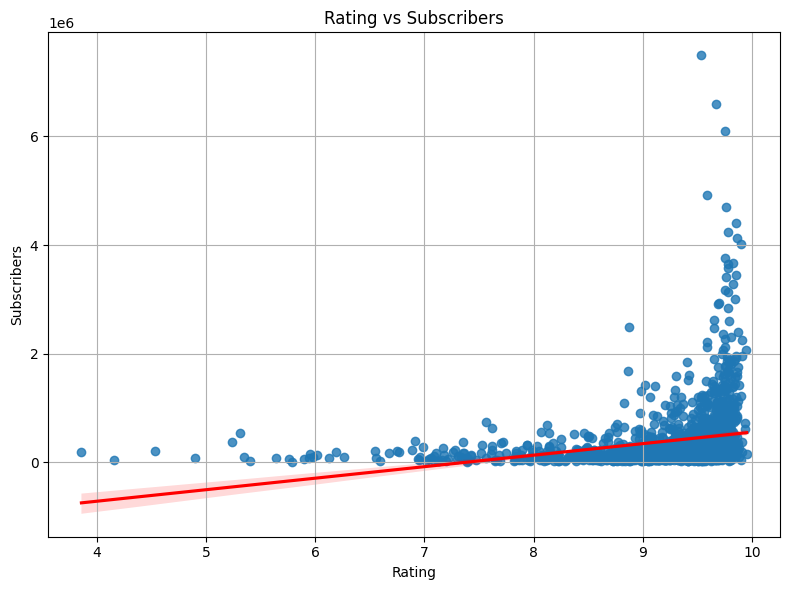

Pearson Correlation Coefficient: 0.2469
P-Value: 2.3305e-23
Statistically significant correlation between rating and subscribers


In [37]:
df_rating_sub = df.dropna(subset=['Rating', 'Subscribers'])

# Scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='Rating', y='Subscribers', data=df_rating_sub, ci=95, line_kws={"color": "red"})
plt.xlabel('Rating')
plt.ylabel('Subscribers')
plt.title('Rating vs Subscribers')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
corr, p_value = pearsonr(df_rating_sub['Rating'], df_rating_sub['Subscribers'])
print(f"Pearson Correlation Coefficient: {corr:.4f}")
print(f"P-Value: {p_value:.4e}")

if p_value < 0.05:
    print("Statistically significant correlation between rating and subscribers")
else:
    print("No statistically signfication correlation between rating and subscribers")

* As shown in the graph, higher ratings have a modest positive correlation with the number of subscribers
    * The increase in ratings correlates with the increase in subscribers but it's not a strong relationship
* The confidence interval gets narrower in the middle, showing that there is more certainty in the average trend within that range
* There's a cluster of high-rated (9-10) webtoons with a wide range of subscribers
* Outliers (blockbuster hits) have huge subscribers but similar ratings to other highly rated titles with lower subscribers
* As the p-value demonstrates, there is statistical significance in correlation between rating and subscribers
* It's important to note that there is a real relationship, but it's not a strong one 
    * Other factors may have impact

## Views vs subscribers

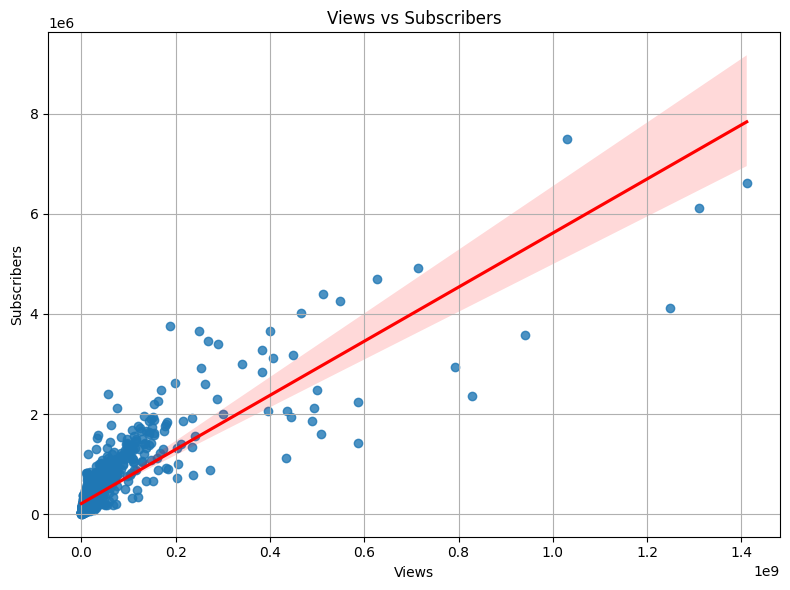

Pearson Correlation Coefficient: 0.8629
P-Value: 0.0000e+00
Statistically significant correlation between views and subscribers


In [38]:
df_views_sub = df.dropna(subset=['Views', 'Subscribers'])

# Scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='Views', y='Subscribers', data=df_views_sub, ci=95, line_kws={"color": "red"})
plt.xlabel('Views')
plt.ylabel('Subscribers')
plt.title('Views vs Subscribers')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
corr, p_value = pearsonr(df_views_sub['Views'], df_views_sub['Subscribers'])
print(f"Pearson Correlation Coefficient: {corr:.4f}")
print(f"P-Value: {p_value:.4e}")

if p_value < 0.05:
    print("Statistically significant correlation between views and subscribers")
else:
    print("No statistically signfication correlation between views and subscribers")

* Views and subscribers have a strong positive correlation (Pearson value is closer to 1)
* P-value is 0, which shows that the correlation is statistically significant
* This relationship is extremely unlikely due to chance
* Most webtoons are clustered in the lower range of subscribers (similar to views)
* Few are in the hundreds of millions or billion views with high subscriber count. But some have fewer subscriber numbers compared to the views
* There is greater uncertainty in the average subscriber count for webtoons that have high views (the shaded area gets larger)
* Views are strong predictor of subscriber count 

## Likes vs subscribers

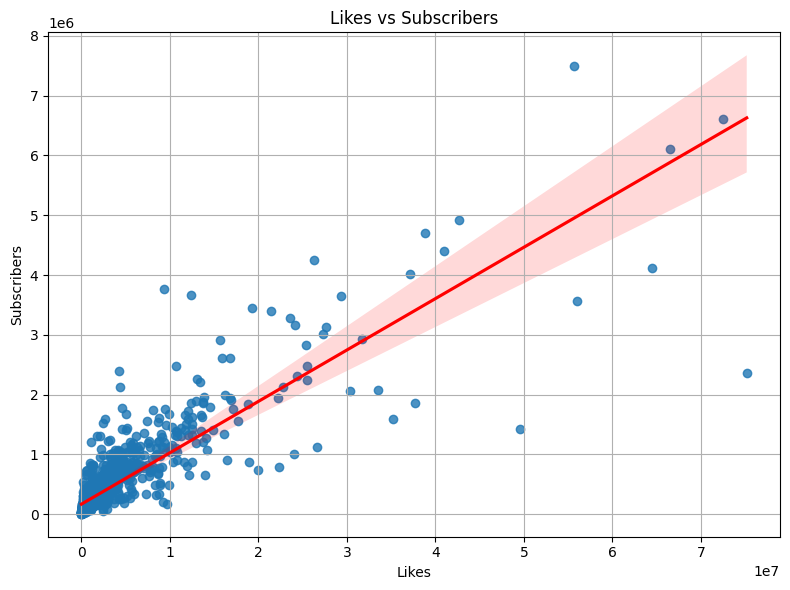

Pearson Correlation Coefficient: 0.8633
P-Value: 0.0000e+00
Statistically significant correlation between likes and subscribers


In [39]:
df_likes_sub = df.dropna(subset=['Likes', 'Subscribers'])

# Scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='Likes', y='Subscribers', data=df_likes_sub, ci=95, line_kws={"color": "red"})
plt.xlabel('Likes')
plt.ylabel('Subscribers')
plt.title('Likes vs Subscribers')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
corr, p_value = pearsonr(df_likes_sub['Likes'], df_likes_sub['Subscribers'])
print(f"Pearson Correlation Coefficient: {corr:.4f}")
print(f"P-Value: {p_value:.4e}")

if p_value < 0.05:
    print("Statistically significant correlation between likes and subscribers")
else:
    print("No statistically signfication correlation between likes and subscribers")

* There is strong positive correlation between likes and subscribers as shown by the graph and pearson correlation coefficient
* p-value is is zero, showing that the relationship is statistically significant
* Confidence interval widens slightly at higher values, suggesting greater variability that can be attributed to fewer data points in that range
* There is dense cluster of webtoons with lower likes and subscriber counts (bottom left)
* A smaller number of webtoons with high likes tend to have a subscriber counts, but there's some scatter 
* Likes are strong predictor of subscribers. Engagement (via likes) is closely tied to a webtoon's following, even slightly more than ratings or on par with views
* Outliers include works that have many likes but fewer subscribers (or vice versa)

## Likes vs rating

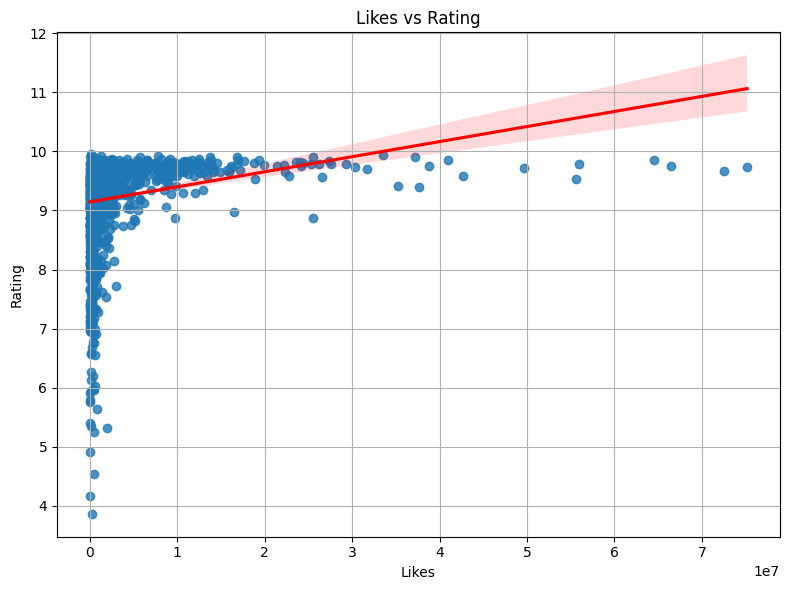

Pearson Correlation Coefficient: 0.2207
P-Value: 7.1674e-19
Statistically significant correlation between likes and rating


In [40]:
df_likes_rating = df.dropna(subset=['Likes', 'Rating'])

# Scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='Likes', y='Rating', data=df_likes_rating, ci=95, line_kws={"color": "red"})
plt.xlabel('Likes')
plt.ylabel('Rating')
plt.title('Likes vs Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
corr, p_value = pearsonr(df_likes_rating['Likes'], df_likes_rating['Rating'])
print(f"Pearson Correlation Coefficient: {corr:.4f}")
print(f"P-Value: {p_value:.4e}")

if p_value < 0.05:
    print("Statistically significant correlation between likes and rating")
else:
    print("No statistically signfication correlation between likes and rating")

* There is weak positive correlation between likes and rating
* Despite the weak correlation, the p-value is extremely low showing that it's not due to random chance
* Webtoons with more likes tend to have higher ratings, but many titles with few likes also have high ratings. The inverse is true, some titles with many likes don't have higher ratings
* Likes may be influenced by popularity or visibility (i.e. marketing, exposure, etc) while ratings are influenced by user satisfaction or quality
* Even for low like counts, there's a large cluster near high ratings (9-10)
* Regression line doesn't fit the data tightly, showing weak correlation

## Likes vs views

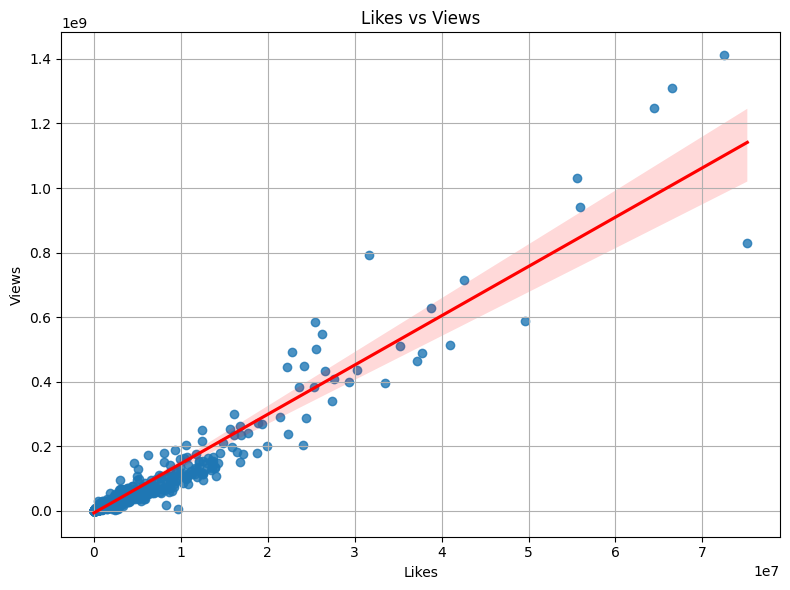

Pearson Correlation Coefficient: 0.9609
P-Value: 0.0000e+00
Statistically significant correlation between likes and rating


In [41]:
df_likes_views = df.dropna(subset=['Likes', 'Views'])

# Scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='Likes', y='Views', data=df_likes_views, ci=95, line_kws={"color": "red"})
plt.xlabel('Likes')
plt.ylabel('Views')
plt.title('Likes vs Views')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
corr, p_value = pearsonr(df_likes_views['Likes'], df_likes_views['Views'])
print(f"Pearson Correlation Coefficient: {corr:.4f}")
print(f"P-Value: {p_value:.4e}")

if p_value < 0.05:
    print("Statistically significant correlation between likes and rating")
else:
    print("No statistically signfication correlation between likes and rating")

## Rating vs views

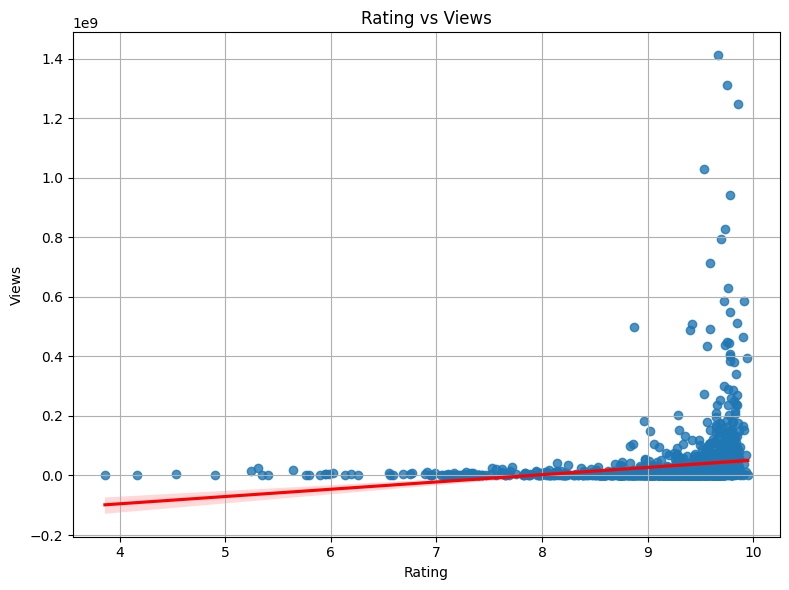

Pearson Correlation Coefficient: 0.1773
P-Value: 1.4192e-12
Statistically significant correlation between likes and rating


In [42]:
df_rating_views = df.dropna(subset=['Rating', 'Views'])

# Scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='Rating', y='Views', data=df_rating_views, ci=95, line_kws={"color": "red"})
plt.xlabel('Rating')
plt.ylabel('Views')
plt.title('Rating vs Views')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
corr, p_value = pearsonr(df_rating_views['Rating'], df_rating_views['Views'])
print(f"Pearson Correlation Coefficient: {corr:.4f}")
print(f"P-Value: {p_value:.4e}")

if p_value < 0.05:
    print("Statistically significant correlation between likes and rating")
else:
    print("No statistically signfication correlation between likes and rating")

## Engagement (likes/views)
* Measure engagement by creating a histogram for likes/views

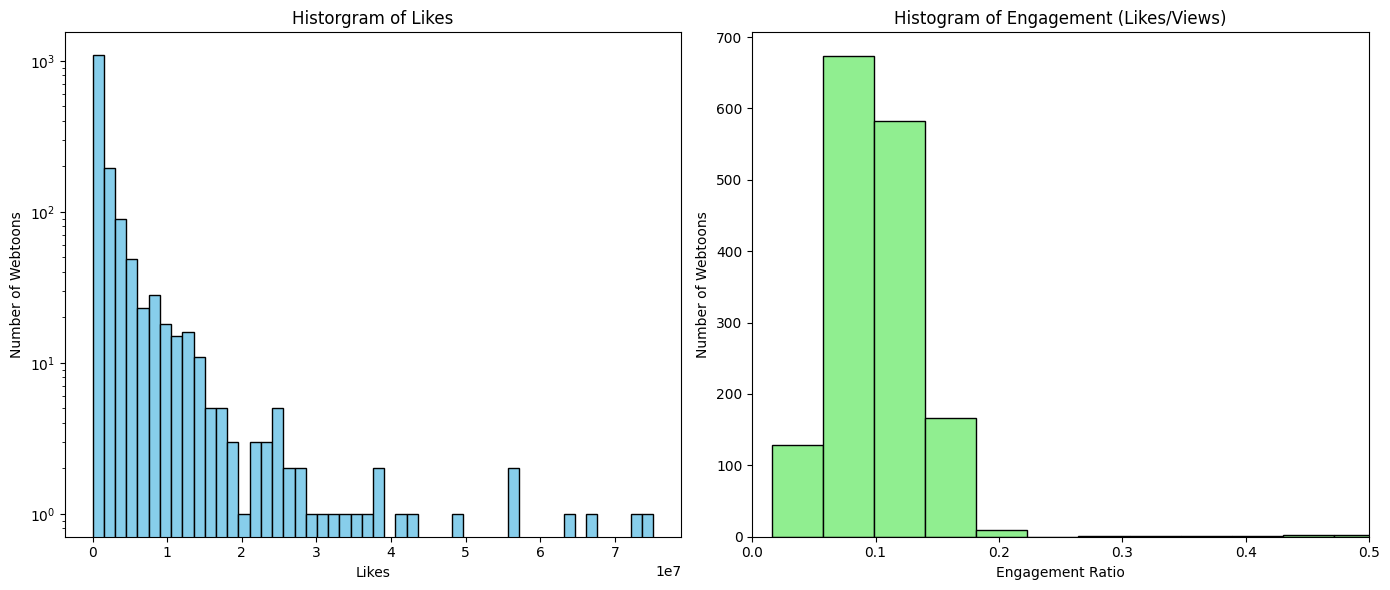

In [43]:
df['Engagement'] = df['Likes'] / df['Views']

plt.figure(figsize=(14, 6))

# Histogram for likes
plt.subplot(1, 2, 1)
plt.hist(df['Likes'], bins=50, color='skyblue', edgecolor='black')
plt.title('Historgram of Likes')
plt.xlabel('Likes')
plt.ylabel('Number of Webtoons')
plt.yscale('log')

# Histogram for engagement
plt.subplot(1, 2, 2)
plt.hist(df['Engagement'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Histogram of Engagement (Likes/Views)')
plt.xlabel('Engagement Ratio')
plt.ylabel('Number of Webtoons')
plt.xlim(0, 0.5)

plt.tight_layout()
plt.show()

Histogram of Likes
* Heavily right-skewed distribution for Webtoon likes, majority have fewer than 10M likes
* Most webtoons have relatively low like counts
* Small number of webtoons have mass popularity (30M - 70M likes)
* Popularity is highly unequal. This is a long tail distribution, which is very common in media consumption

Histogram of Engagement
* Most webtoons fall between 5% - 15% (0.05 - 0.15) engagement
* Peak around 8% - 10%, which indicates that 1 in 10 viewers like the webtoon
* Only very few titles have above 20% engagement. There are some outliers that have 30% - 40%
* Likes are skewed, but engagement has more normal distribution

## Engagement vs rating

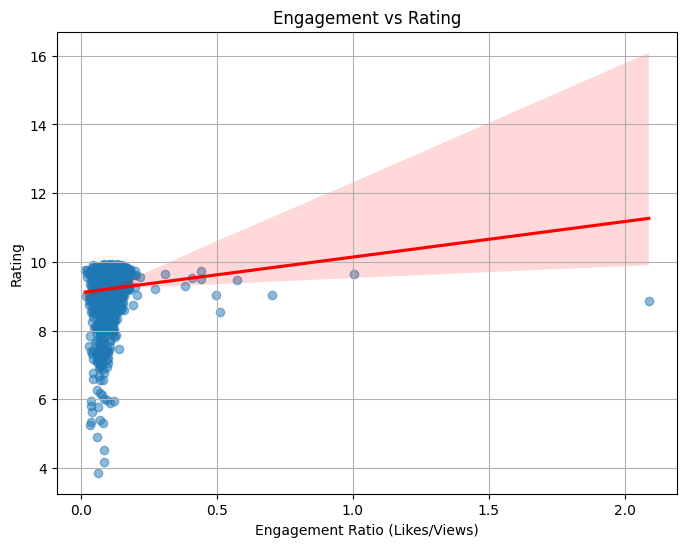

Pearson Correlation Coefficient: 0.1019
P-Value: 5.1886e-05


In [44]:
plt.figure(figsize=(8, 6))
sns.regplot(data=df, x='Engagement', y='Rating', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Engagement vs Rating')
plt.xlabel('Engagement Ratio (Likes/Views)')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

clean_df = df[['Engagement', 'Rating']].replace([np.inf, -np.inf], np.nan).dropna()

corr, p_val = pearsonr(clean_df['Engagement'], clean_df['Rating'])
print(f"Pearson Correlation Coefficient: {corr:.4f}")
print(f"P-Value: {p_val:.4e}")
df_filtered = df[df['Engagement'] < 0.5]  # remove extreme outliers

* Very weak positive correlation. The pearson coefficient is near 0, showing that there is little linear relationship between engagment and rating
* The p-value is very small, showing that the result is statistically signficiant and did not occur by random chance
* For engagment ratio and rating, there is statistical significance but weak popsitive relationship
* Webtoons with higher like-to-view ratios get slighlty better ratings, but the effect is minimal
* Ratings are generally high regardless of engagment and many title with low engagement have high ratings

## Engagement vs subscribers

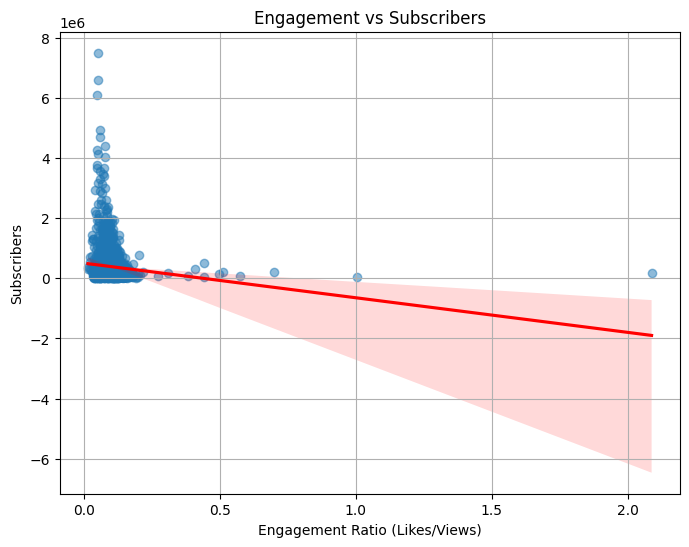

Pearson Correlation Coefficient: -0.1313
P-Value: 1.7421e-07


In [45]:
plt.figure(figsize=(8, 6))
sns.regplot(data=df, x='Engagement', y='Subscribers', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Engagement vs Subscribers')
plt.xlabel('Engagement Ratio (Likes/Views)')
plt.ylabel('Subscribers')
plt.grid(True)
plt.show()

clean_df = df[['Engagement', 'Subscribers']].replace([np.inf, -np.inf], np.nan).dropna()

corr, p_val = pearsonr(clean_df['Engagement'], clean_df['Subscribers'])
print(f"Pearson Correlation Coefficient: {corr:.4f}")
print(f"P-Value: {p_val:.4e}")
df_filtered = df[df['Engagement'] < 0.5]  # remove extreme outliers

* Engagement ratios and subscriber counts are weakly negatively correlated
* High subscriber numbers do not necessarily translate to high engagement on a per-view basis
* The negative correlation, although weak, is unlikely due to chance
* Possible reasons:
    * Smaller audiences are more devoted (liking more often per view)
    * Larger titles attract more passive or casual readers, lowering engagement ratio

# Time-based

## Subscribers by schedule

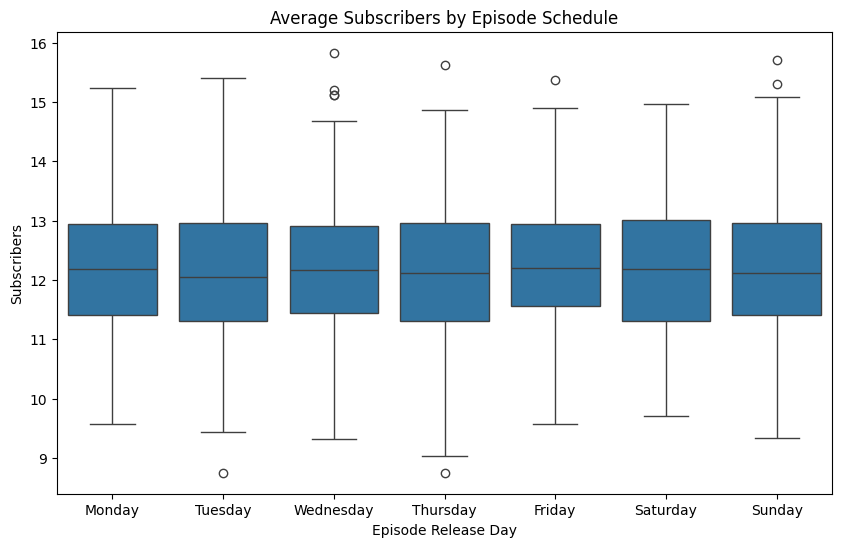

ANOVA F-statistic: 0.1647
P-value: 9.8603e-01
Subscribers do not differ significantly by the episode's release day


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/3130385475.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['Subscribers'].dropna() for name, group in df.groupby('Schedule')]


In [46]:
df['Schedule'] = df['Schedule'].dropna().str.strip().str.title()
df['Schedule'] = df['Schedule'].str.split(',')
df = df.explode('Schedule')
df['Schedule'] = df['Schedule'].str.strip()
valid_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df = df[df['Schedule'].isin(valid_days)]
df['Schedule'] = pd.Categorical(df['Schedule'], categories=valid_days, ordered=True)
df['LogSubscribers'] = np.log1p(df['Subscribers']) # Reduce extreme skews in boxplot (outliers)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Schedule', y='LogSubscribers')
plt.title('Average Subscribers by Episode Schedule')
plt.xlabel('Episode Release Day')
plt.ylabel('Subscribers')
plt.show()

groups = [group['Subscribers'].dropna() for name, group in df.groupby('Schedule')]

f_stat, p_val = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4e}")
if p_val < 0.05:
    print("Subscribers differ significantly by the episode's release day of the week")
else:
    print("Subscribers do not differ significantly by the episode's release day")

## Rating by schedule

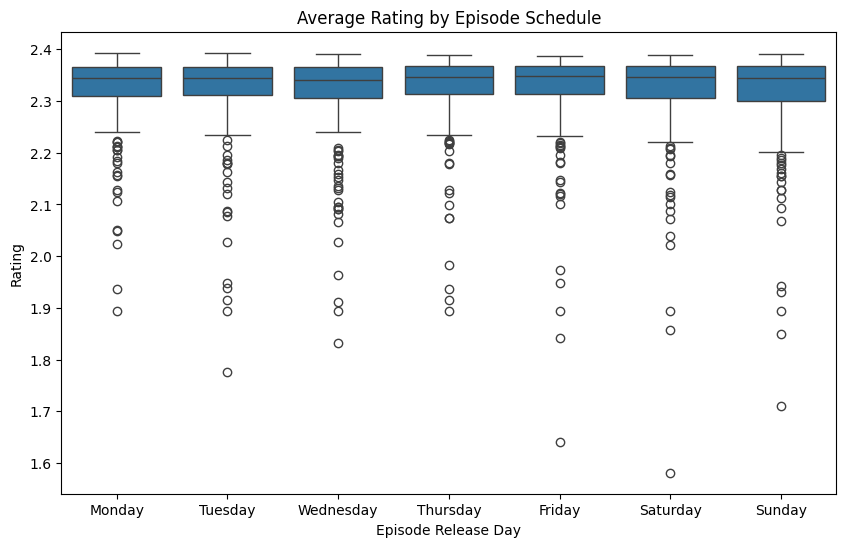

ANOVA F-statistic: 0.5067
P-value: 8.0366e-01
Rating does not differ significantly by the episode's release day


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/3936473151.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['Rating'].dropna() for name, group in df.groupby('Schedule')]


In [47]:
df['LogRating'] = np.log1p(df['Rating']) # Reduce extreme skews in boxplot (outliers)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Schedule', y='LogRating')
plt.title('Average Rating by Episode Schedule')
plt.xlabel('Episode Release Day')
plt.ylabel('Rating')
plt.show()

groups = [group['Rating'].dropna() for name, group in df.groupby('Schedule')]

f_stat, p_val = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4e}")
if p_val < 0.05:
    print("Rating differs significantly by the episode's release day of the week")
else:
    print("Rating does not differ significantly by the episode's release day")

## Engagement by schedule

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/1136288971.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_engagement = df.groupby('Schedule')['Engagement'].mean().reset_index()
/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/1136288971.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_engagement, x='Schedule', y='Engagement', palette='viridis')


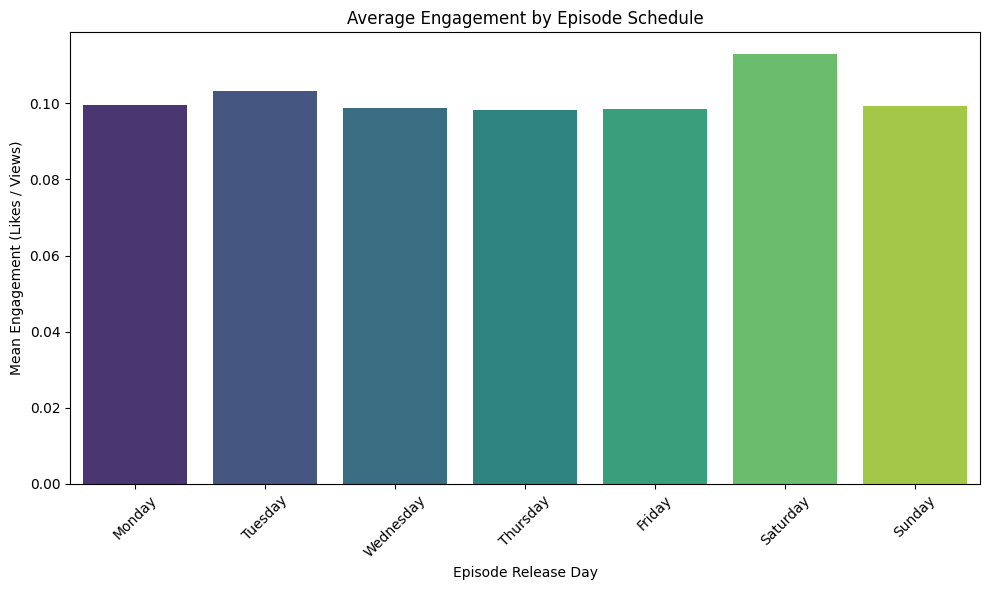

ANOVA F-statistic: 1.6280
P-value: 1.3549e-01
Engagement does not differ significantly by the episode's release day


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_8449/1136288971.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['Engagement'].dropna() for name, group in df.groupby('Schedule')]


In [48]:
mean_engagement = df.groupby('Schedule')['Engagement'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=mean_engagement, x='Schedule', y='Engagement', palette='viridis')
plt.title('Average Engagement by Episode Schedule')
plt.xlabel('Episode Release Day')
plt.ylabel('Mean Engagement (Likes / Views)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

groups = [group['Engagement'].dropna() for name, group in df.groupby('Schedule')]

f_stat, p_val = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4e}")
if p_val < 0.05:
    print("Engagement differs significantly by the episode's release day of the week")
else:
    print("Engagement does not differ significantly by the episode's release day")

## Genres by schedule

Chi-square statistic: 127.65
P-value: 5.9088e-01
Genre does not differ significantly by the episode's release day


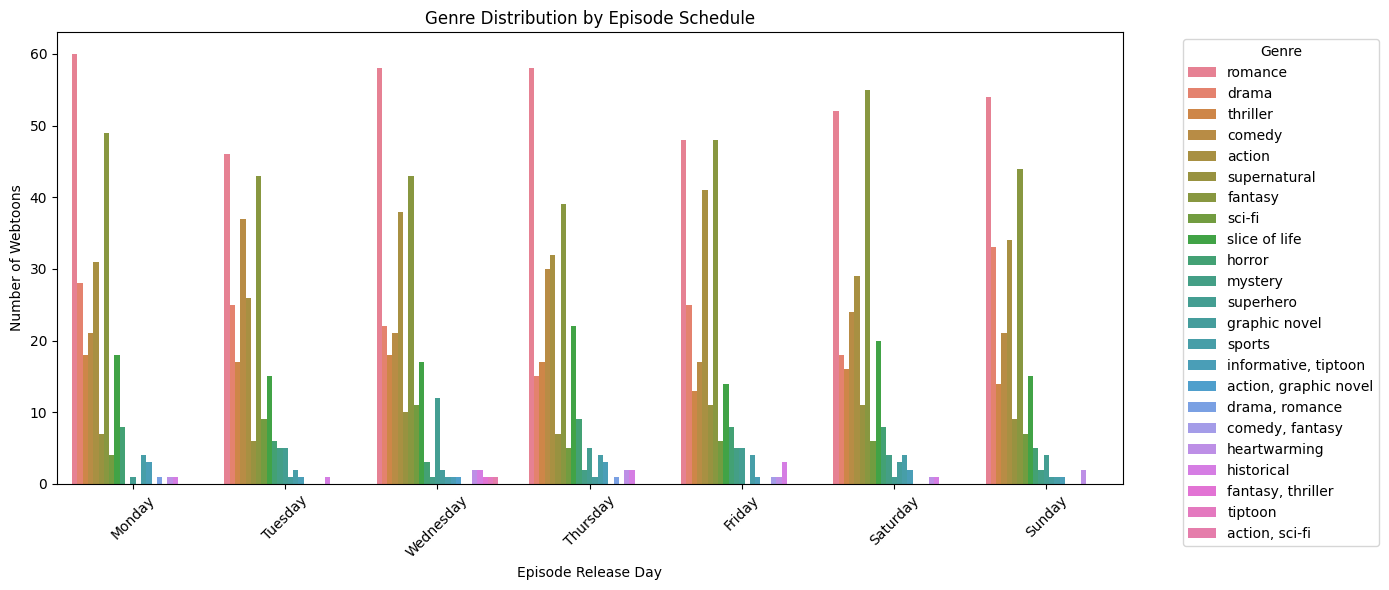

In [49]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='Schedule', hue='Genre', dodge=True)
plt.title('Genre Distribution by Episode Schedule')
plt.xlabel('Episode Release Day')
plt.ylabel('Number of Webtoons')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Genre')
plt.tight_layout()
plt.show

contingency_table = pd.crosstab(df['Genre'], df['Schedule'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.4e}")
if p < 0.05:
    print("Genre differs significantly by the episode's release day of the week")
else:
    print("Genre does not differ significantly by the episode's release day")

## Genre by release year

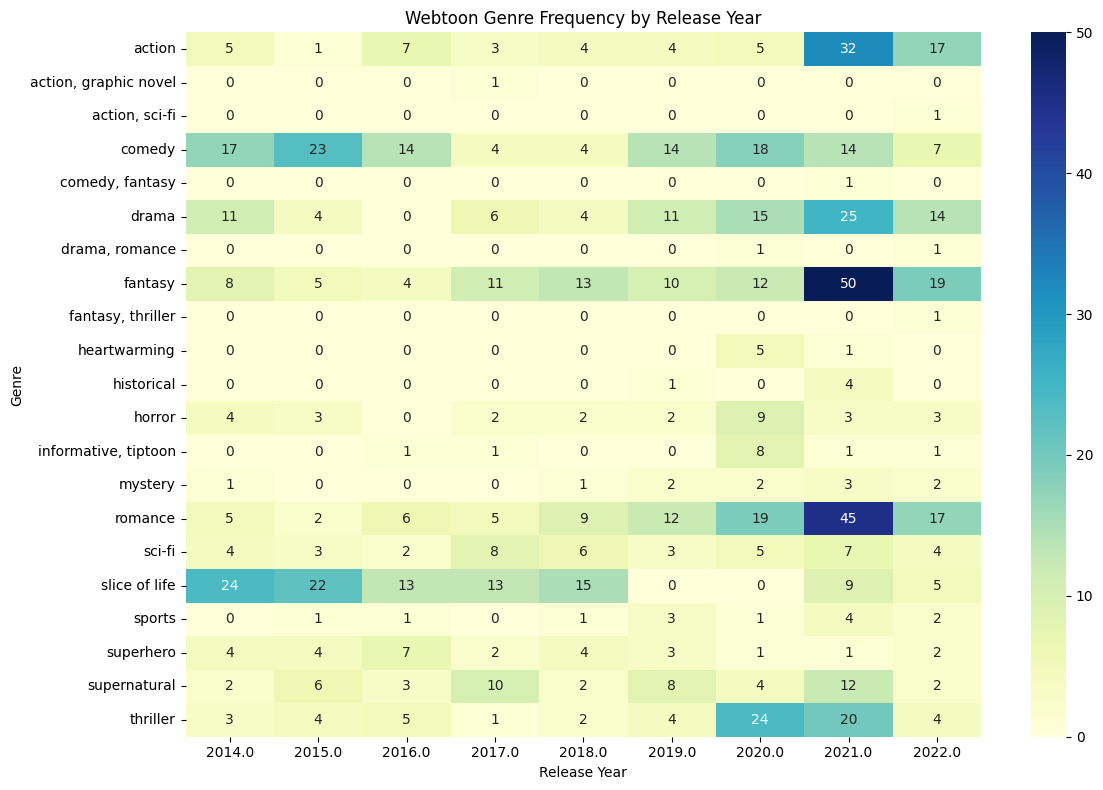

Chi-square statistic: 431.14
P-value: 9.4802e-27
Genre does not differ significantly over time


In [50]:
genre_year_counts = pd.crosstab(df['Genre'], df['Release Date'])

plt.figure(figsize=(12, 8))
sns.heatmap(genre_year_counts, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Webtoon Genre Frequency by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

contingency_table = pd.crosstab(df['Genre'], df['Release Date'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.4e}")
if p_val < 0.05:
    print("Genre differs significantly over time")
else:
    print("Genre does not differ significantly over time")

## Rating over time

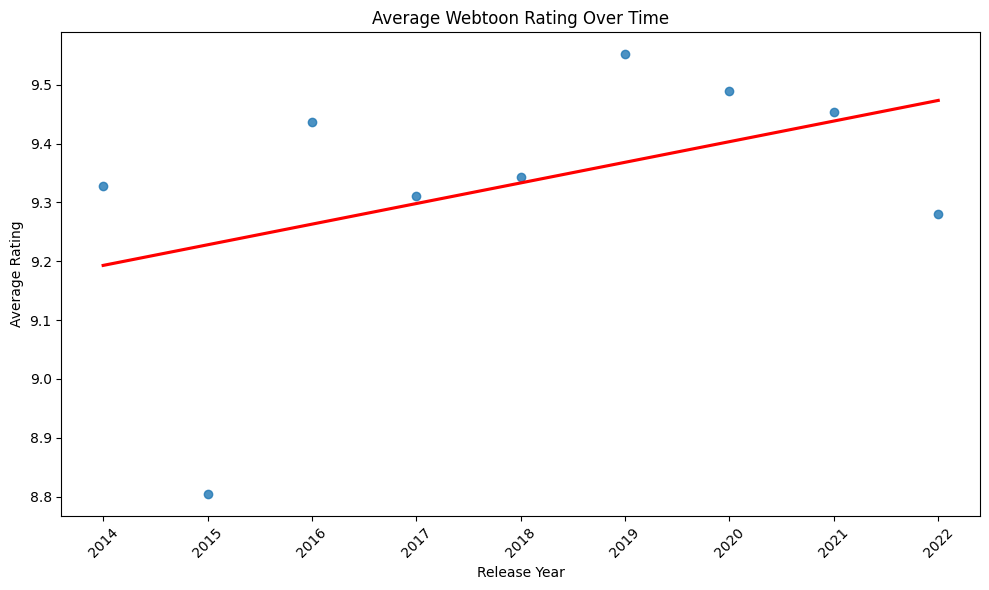

Pearson Correlation Coefficient: 0.4401
P-value: 2.3589e-01
Genre does not differ significantly by the episode's release day


In [51]:
avg_rating_per_year = df.groupby('Release Date')['Rating'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.regplot(data=avg_rating_per_year, x='Release Date', y='Rating', marker='o', ci=None, line_kws={"color": "red"})

plt.title('Average Webtoon Rating Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

corr, p_val = pearsonr(avg_rating_per_year['Release Date'], avg_rating_per_year['Rating'])
print(f"Pearson Correlation Coefficient: {corr:.4f}")
print(f"P-value: {p_val:.4e}")
if p_val < 0.05:
    print("Genre differs significantly by the episode's release day of the week")
else:
    print("Genre does not differ significantly by the episode's release day")

## Subscriber trend over time

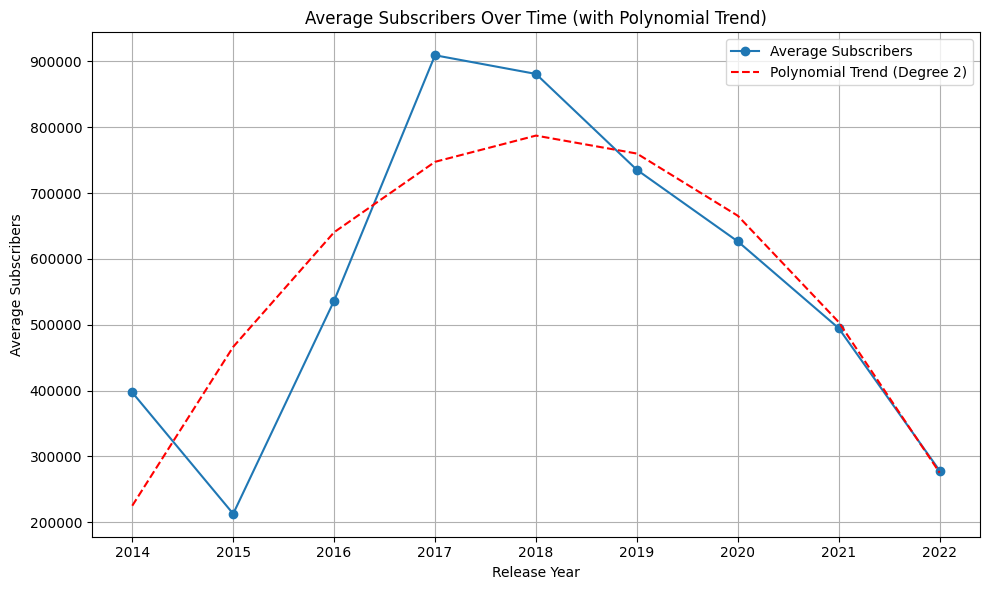

ANOVA F-statistic: 9.3124, P-value: 2.1556e-12
According to ANOVA, average subscribers differ significantly over time


In [52]:
avg_subs = df.groupby('Release Date')['Subscribers'].mean().reset_index()

X = avg_subs['Release Date'].values.reshape(-1, 1)
y = avg_subs['Subscribers'].values 

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)
y_pred = model.predict(X_poly)

plt.figure(figsize=(10, 6))
plt.plot(avg_subs['Release Date'], y, 'o-', label='Average Subscribers')
plt.plot(avg_subs['Release Date'], y_pred, 'r--', label='Polynomial Trend (Degree 2)')
plt.title('Average Subscribers Over Time (with Polynomial Trend)')
plt.xlabel('Release Year')
plt.ylabel('Average Subscribers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

groups = [group['Subscribers'].dropna() for name, group in df.groupby('Release Date')]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.4f}, P-value: {p_val:.4e}")
if p_val < 0.05:
    print("According to ANOVA, average subscribers differ significantly over time")
else:
    print("According to ANOVA, average subscribers do not differ significantly over time")

* Peaks in 2017 - 2018, but steady decline afterward
* Lower engagement in 2015 and 2022
* Bell-shaped trend
* Average number of subscribers differs significantly across years
* No significant linear relationship between release year and subscriber count
* Subscriber trend over time is non-linear

## Clean and combine data
* Only include metrics that have shown to be statistically significant
* Two datasets will be created:
1. Everything except for Schedule and Release Date
    * The Release Date (year) is not significant in most tests, we'll create a speparate datset that we could use if we wanted to see subscriber trends over time
2. Everything except for Schedule 

In [53]:
# Create combined file with only features that have shown to be statistically significant. Remove any titles that are missing data in any of those features

we_combined['Engagement'] = (we_combined['Likes'] / we_combined['Views']).round(3)
required_columns = ['Title', 'Creators', 'Genre', 'Rating', 'Views', 'Likes', 'Engagement', 'Subscribers', 'Synopsis']
we_combined_two = we_combined.dropna(subset=required_columns).reset_index(drop=True)
we_combined_two = we_combined_two[required_columns]
pd.concat([we_combined_two.head(3), we_combined_two.tail(3)])

,Title,Creators,Genre,Rating,Views,Likes,Engagement,Subscribers,Synopsis
0,This Wasn't My Plan,"BOM SOHEE, SEI KIM",romance,8.60,5.139129e+06,509745,0.099,126211,"In a twist of fate, Ro-a finds herself thrown back a decade in time. This isn't just a trip down memory lane. She's faced with a younger, naive Sihyeon, the future superstar who would brutally wrong her. Armed with knowledge of what's to come, Ro-a sees a golden opportunity: a chance to rewrite their history. Can she resist the allure of revenge and change Sihyeon's destiny before he becomes her nightmare?\n"
1,#Blessed,M. Victoria Robado,drama,9.18,2.243092e+07,2055736,0.092,438390,"Joanna is a mid-twenties office girl who likes social media and watered down coffee. While griping about her love life, she accidentally swiped right on a whole Pantheon of Gods and Goddesses! Looking to fulfill an ancient prophecy, only one of them will be able to claim Joanna as their own... after a nice dinner, that is!"
2,#Killstagram,Ryoung,thriller,9.31,4.545950e+07,3816843,0.084,933881,"Remi Do has everything -- she's super pretty, has the best brand sponsorships on social media, and gets 10,000 likes within seconds of posting a selfie. Oh, and she also has a serial-killing stalker following her every move."
1557,unOrdinary,uru-chan,superhero,9.75,1.310897e+09,66472813,0.051,6106443,"Nobody paid much attention to John , just a normal teenager at a high school where the social elite happen to possess unthinkable powers and abilities. But John's got a secret past that threatens to bring down the school's whole social order , and much more. Fulfilling his destiny won't be easy though, because there are battles, frenemies and deadly conspiracies around every corner."
1558,unTouchable,massstar,romance,9.69,1.732905e+08,6176229,0.036,1300000,Sia is a modern-day vampire who absorbs energy from humans by touching them instead of drinking their blood. She has been desperate to touch Jiho since the day he moved in next door -- but he's a germaphobe. Will Sia best his mysophobia and get to touch Jiho?
1559,ㄴㅇㄹㅇㄴㄹ,LOZOLZ,"informative, tiptoon",8.82,6.523004e+06,268565,0.041,108254,"The mysterious team that brings Webtoon to you. LOZOLZ, pass it on."


## Webtoon popularity
* Measure the popularity of webtoon building a composite webtoon popularity metric
    * Identify key drivers of popularity using PCA
    * Validiate it using regression

In [54]:
# Normalize popularity features by using Min-Max scaling
popularity_cols = ['Views', 'Subscribers', 'Rating', 'Likes', 'Engagement']
df_pop = df.dropna(subset=popularity_cols)
X = df_pop[popularity_cols]
scaler = MinMaxScaler() # Scale the data
X_scaled = scaler.fit_transform(X)

# Run PCA
pca = PCA()
pca.fit(X_scaled)

# Get explained variance and loadings
explained_variance = pca.explained_variance_ratio_
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=popularity_cols
)
print("Explained Variance:", explained_variance)
print("\nPCA Loadings:\n", loadings.round(3))


Explained Variance: [0.57269304 0.35359616 0.03999254 0.02736021 0.00635805]

PCA Loadings:
              PC1    PC2    PC3    PC4    PC5  
Views        0.426 -0.312 -0.211 -0.164  0.806
Subscribers  0.473 -0.268  0.766  0.331 -0.086
Rating       0.547  0.835 -0.020 -0.055  0.018
Likes        0.543 -0.362 -0.484 -0.097 -0.574
Engagement  -0.005  0.052 -0.365  0.923  0.114


For the 'PopularityScore', we will distribute weights according to PC1 loadings
* PC1 explains 57.3% of the total variance while PC2 adds another 35.4%. We will only focus only on PC1 for weighting since the other ones explain very little

In [55]:
# Raw PC1 loadings
pc1_loadings = {
    'Views': 0.426,
    'Subscribers': 0.473,
    'Rating': 0.547,
    'Likes': 0.543,
    'Engagement': -0.005
}

# Remove low-impact variables (e.g., absolute loading < 0.1)
filtered = {k: abs(v) for k, v in pc1_loadings.items() if abs(v) > 0.1}

# Normalize
total = sum(filtered.values())
weights = {k: v / total for k, v in filtered.items()}
print("Normalized Weights (based on PCA PC1):")
for k, v in weights.items():
    print(f"{k}: {v:.2f}")

Normalized Weights (based on PCA PC1):
Views: 0.21
Subscribers: 0.24
Rating: 0.28
Likes: 0.27


In [56]:
we_combined_two['PopularityScore'] = (
    0.21 * we_combined_two['Views'] +
    0.24 * we_combined_two['Subscribers'] +
    0.28 * we_combined_two['Rating'] +
    0.27 * we_combined_two['Likes']
)

# Check pearson correlation with Subscribers, Views, Rating, and Likes
for col in ['Subscribers', 'Views', 'Likes', 'Rating']:
    corr, pval = pearsonr(we_combined_two['PopularityScore'], we_combined_two[col])
    print(f"Correlation with {col}: {corr:.4f} (p-value: {pval:.2e})")

Correlation with Subscribers: 0.8670 (p-value: 0.00e+00)
Correlation with Views: 0.9998 (p-value: 0.00e+00)
Correlation with Likes: 0.9666 (p-value: 0.00e+00)
Correlation with Rating: 0.1828 (p-value: 3.48e-13)


In [76]:
# Drop rows with missing values in the required columns
popularity_cols = ['Views', 'Subscribers', 'Rating', 'Likes', 'Engagement']
we_combined_two_clean = we_combined_two.dropna(subset=popularity_cols).copy()
we_combined_two.loc[we_combined_two_clean.index, 'Popularity'] = we_combined_two_clean['Popularity']
desired_order = ['Title', 'Creators', 'Genre', 'Rating', 'Views', 'Likes', 'Engagement', 'Subscribers', 'Popularity', 'Synopsis']
we_combined_two['Popularity'] = we_combined_two['Popularity'].round(3)
we_combined_two = we_combined_two[desired_order]

In [81]:
print('Before:', len(we_combined))
print('After: ', len(we_combined_two))
pd.concat([we_combined_two.head(3), we_combined_two.tail(3)])

Before: 1579
After:  1560


,Title,Creators,Genre,Rating,Views,Likes,Engagement,Subscribers,Popularity,Synopsis
0,This Wasn't My Plan,"BOM SOHEE, SEI KIM",romance,8.60,5.139129e+06,509745,0.099,126211,0.004,"In a twist of fate, Ro-a finds herself thrown back a decade in time. This isn't just a trip down memory lane. She's faced with a younger, naive Sihyeon, the future superstar who would brutally wrong her. Armed with knowledge of what's to come, Ro-a sees a golden opportunity: a chance to rewrite their history. Can she resist the allure of revenge and change Sihyeon's destiny before he becomes her nightmare?\n"
1,#Blessed,M. Victoria Robado,drama,9.18,2.243092e+07,2055736,0.092,438390,0.017,"Joanna is a mid-twenties office girl who likes social media and watered down coffee. While griping about her love life, she accidentally swiped right on a whole Pantheon of Gods and Goddesses! Looking to fulfill an ancient prophecy, only one of them will be able to claim Joanna as their own... after a nice dinner, that is!"
2,#Killstagram,Ryoung,thriller,9.31,4.545950e+07,3816843,0.084,933881,0.034,"Remi Do has everything -- she's super pretty, has the best brand sponsorships on social media, and gets 10,000 likes within seconds of posting a selfie. Oh, and she also has a serial-killing stalker following her every move."
1557,unOrdinary,uru-chan,superhero,9.75,1.310897e+09,66472813,0.051,6106443,0.928,"Nobody paid much attention to John , just a normal teenager at a high school where the social elite happen to possess unthinkable powers and abilities. But John's got a secret past that threatens to bring down the school's whole social order , and much more. Fulfilling his destiny won't be easy though, because there are battles, frenemies and deadly conspiracies around every corner."
1558,unTouchable,massstar,romance,9.69,1.732905e+08,6176229,0.036,1300000,0.121,Sia is a modern-day vampire who absorbs energy from humans by touching them instead of drinking their blood. She has been desperate to touch Jiho since the day he moved in next door -- but he's a germaphobe. Will Sia best his mysophobia and get to touch Jiho?
1559,ㄴㅇㄹㅇㄴㄹ,LOZOLZ,"informative, tiptoon",8.82,6.523004e+06,268565,0.041,108254,0.005,"The mysterious team that brings Webtoon to you. LOZOLZ, pass it on."


In [82]:
we_combined_two.to_csv("data/combined/clean/we_combined_clean.csv", index=False)